In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

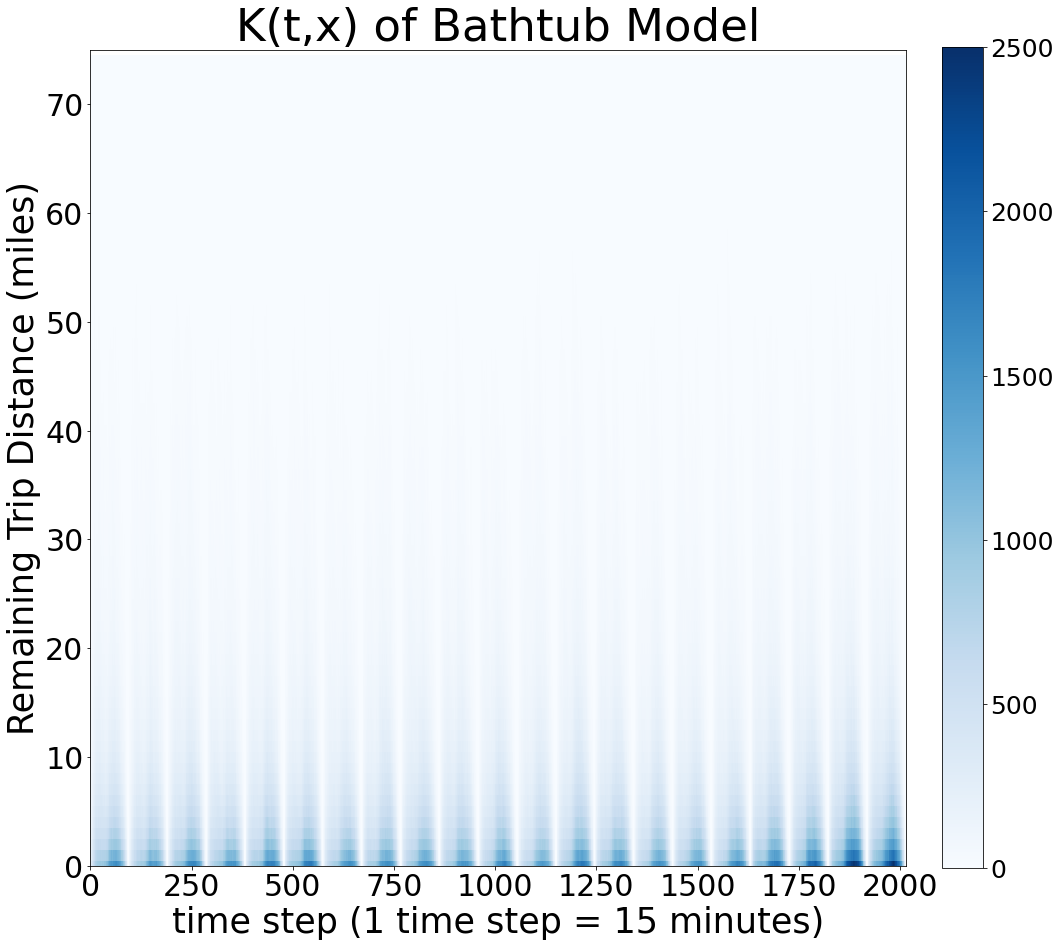

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 25 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  6048
N_u =  1209
N_f =  2418


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(1209, 2)

In [12]:
X_u_test.shape

(4839, 2)

In [13]:
X_u_train

array([[0.33783784, 0.02977667],
       [0.33783784, 0.2808933 ],
       [0.33783784, 0.55632754],
       ...,
       [0.67567568, 0.08337469],
       [0.67567568, 0.03176179],
       [0.33783784, 0.13052109]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u
    
    def loss(self,x,y):

        loss_u = self.loss_BC(x,y)

        loss = loss_u

        return loss, loss_u
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u= self.loss(X_u_train, u_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u = self.loss(X_u_train, u_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        
        tf.print(loss_value, loss_u, error_vec)

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.04348716089055036 0.04348716089055036 0.7580449247632018
0.033461282366443364 0.033461282366443364 0.6633768915425586
0.023965641025658922 0.023965641025658922 0.557679877889291
0.023312600239412246 0.023312600239412246 0.5513682973891774
0.023128462577713286 0.023128462577713286 0.5505143008620332
0.022742245620525056 0.022742245620525056 0.5459196525410782
0.021791263469721808 0.021791263469721808 0.5339326503583476
0.021305735181080036 0.021305735181080036 0.527599639795221
0.020678349950041964 0.020678349950041964 0.5196334183490815
0.020223390886155556 0.020223390886155556 0.5129752065243603
0.019461130131893968 0.019461130131893968 0.5017475388219661
0.019108431268900064 0.019108431268900064 0.49678612349078305
0.018588665125903965 0.018588665125903965 0.4898429576895186
0.017728922111044529 0.017728922111044529 0.4783519934055961
0.017409582423994027 0.017409582423994027 0.4738853825906356
0.016465677620360317 0.016465677620360317 0.4598752867235544
0.015815398491537108 0.0158

0.014047925059718752 0.014047925059718752 0.42184694335078804
0.014047912533437252 0.014047912533437252 0.4218478499863436
0.014047907924158939 0.014047907924158939 0.42184762751282723
0.014047905249255347 0.014047905249255347 0.4218477273208925
0.014047901251244154 0.014047901251244154 0.4218480991353417
0.014047892960881957 0.014047892960881957 0.4218487388826526
0.014047869194241176 0.014047869194241176 0.42185020580945526
0.014047818938069131 0.014047818938069131 0.42185301821420834
0.01404771903336887 0.01404771903336887 0.42185708399248084
0.014047610900380585 0.014047610900380585 0.4218737257311517
0.01404748118078537 0.01404748118078537 0.42187060811584676
0.014047264873630557 0.014047264873630557 0.4218713713930035
0.014046714417795043 0.014046714417795043 0.42186445727604005
0.014046474304365094 0.014046474304365094 0.421851047362061
0.014046138390058905 0.014046138390058905 0.4218449927965288
0.01404593848905185 0.01404593848905185 0.4218325086241317
0.014045898279094096 0.0

0.014038296356047131 0.014038296356047131 0.4218201153529731
0.014038293192293442 0.014038293192293442 0.42182126070090176
0.014038290611526649 0.014038290611526649 0.42182072537699533
0.014038287731769244 0.014038287731769244 0.42181977804295845
0.014038283639647564 0.014038283639647564 0.4218178649338652
0.014038277340749658 0.014038277340749658 0.4218173827875159
0.014038268555252894 0.014038268555252894 0.42181646434978987
0.014038258610938379 0.014038258610938379 0.42182002228223325
0.014038251317940063 0.014038251317940063 0.42181769628908616
0.014038247001484911 0.014038247001484911 0.42181760915704675
0.014038244446685817 0.014038244446685817 0.42181821241368406
0.014038232709339318 0.014038232709339318 0.4218346531860309
0.014038223233338703 0.014038223233338703 0.4218258953694171
0.014038219105520002 0.014038219105520002 0.4218221312745001
0.014038214699464121 0.014038214699464121 0.4218226662360507
0.014038208639885988 0.014038208639885988 0.4218245586253942
0.01403820806451

0.014037884770599895 0.014037884770599895 0.4218068474392425
0.014037881385700933 0.014037881385700933 0.42180567484797277
0.014037878878997568 0.014037878878997568 0.42180661835931293
0.014037875180930722 0.014037875180930722 0.42180732873039656
0.014037869702907107 0.014037869702907107 0.4218077719955071
0.014037868206566134 0.014037868206566134 0.421807760577405
0.014037862324594679 0.014037862324594679 0.42180875842079263
0.014037858402226872 0.014037858402226872 0.4218079683810104
0.014037855694697853 0.014037855694697853 0.4218064898859958
0.014037851336488494 0.014037851336488494 0.4218014179289731
0.01403784755491861 0.01403784755491861 0.4218016488826412
0.014037843195636767 0.014037843195636767 0.4218051189091894
0.014037837345938014 0.014037837345938014 0.4218026343805157
0.014037833495075007 0.014037833495075007 0.4218015083880814
0.014037830606436008 0.014037830606436008 0.4218049087107939
0.014037825883130217 0.014037825883130217 0.421807075190396
0.014037823800356277 0.0

0.01403750644516992 0.01403750644516992 0.42178725564034564
0.014037506242839335 0.014037506242839335 0.4217879370263781
0.014037506001842434 0.014037506001842434 0.42178923822685094
0.014037505741193463 0.014037505741193463 0.4217883579362293
0.014037505476532987 0.014037505476532987 0.4217878034723307
0.014037504975237607 0.014037504975237607 0.42178710496751026
0.014037504409601862 0.014037504409601862 0.4217869639184143
0.014037504060176667 0.014037504060176667 0.42178675039550084
0.014037503753013766 0.014037503753013766 0.4217872496802055
0.014037503143383782 0.014037503143383782 0.42178832814307227
0.014037502722069451 0.014037502722069451 0.4217889158196014
0.014037501979658414 0.014037501979658414 0.42178915820935015
0.014037501242014319 0.014037501242014319 0.421788686713078
0.014037500608922766 0.014037500608922766 0.421787687991067
0.014037500225717056 0.014037500225717056 0.4217878951404453
0.014037499938539458 0.014037499938539458 0.4217881663310414
0.014037499654158675 0

0.014037371935527738 0.014037371935527738 0.42178347394786037
0.014037371196848433 0.014037371196848433 0.4217835886411904
0.014037370603960249 0.014037370603960249 0.42178400422982015
0.014037370316232877 0.014037370316232877 0.42178414947625176
0.014037370010613592 0.014037370010613592 0.4217843759144739
0.014037369605409527 0.014037369605409527 0.42178460147755775
0.014037368624317122 0.014037368624317122 0.4217848155867944
0.014037367186313408 0.014037367186313408 0.42178483716517795
0.014037366520940441 0.014037366520940441 0.42178485030790175
0.014037364128145836 0.014037364128145836 0.4217846526247649
0.014037360404789727 0.014037360404789727 0.42178352655660034
0.014037357708899903 0.014037357708899903 0.42178252856836473
0.01403735637672641 0.01403735637672641 0.4217822053611519
0.014037353738022482 0.014037353738022482 0.4217820090896385
0.014037349463311156 0.014037349463311156 0.42178461864647915
0.014037346999400535 0.014037346999400535 0.4217839715276851
0.014037339348931

0.014036637729944524 0.014036637729944524 0.4217304509306467
0.014036631028900244 0.014036631028900244 0.4217348248702529
0.01403662706927894 0.01403662706927894 0.4217320999445998
0.014036623305431989 0.014036623305431989 0.42173157247116067
0.01403662192257156 0.01403662192257156 0.4217309798711272
0.014036621099614517 0.014036621099614517 0.4217288077867799
0.014036619787627628 0.014036619787627628 0.4217301115429698
0.01403661938232875 0.01403661938232875 0.42172982602321146
0.014036618465748059 0.014036618465748059 0.42172974993101225
0.014036616926702871 0.014036616926702871 0.4217291358851738
0.014036612609575007 0.014036612609575007 0.4217276612893963
0.014036608697485971 0.014036608697485971 0.42172644958690664
0.014036596405482453 0.014036596405482453 0.42172524490117913
0.014036581222853419 0.014036581222853419 0.4217195769448383
0.014036570083856233 0.014036570083856233 0.4217194841365705
0.014036561579018678 0.014036561579018678 0.42172350859152097
0.01403653367595575 0.01

0.014020635513053622 0.014020635513053622 0.4218674096080406
0.014020600907386202 0.014020600907386202 0.4218639732591028
0.014020485314005373 0.014020485314005373 0.42184138638129803
0.014020241965754882 0.014020241965754882 0.4218408185675614
0.014019864261286744 0.014019864261286744 0.42185084467035894
0.014019690954812166 0.014019690954812166 0.42184558532535676
0.014019541501248968 0.014019541501248968 0.4218667620353416
0.0140193403926154 0.0140193403926154 0.4218356580681425
0.014019057792436151 0.014019057792436151 0.42186269050898284
0.014018895259865209 0.014018895259865209 0.4218803698747749
0.014018635748403421 0.014018635748403421 0.4218772114033612
0.014018246961819454 0.014018246961819454 0.4218947652720699
0.014017928466892121 0.014017928466892121 0.4219304413303798
0.014017713737611806 0.014017713737611806 0.42195625992857916
0.014017567564237738 0.014017567564237738 0.4219860606056935
0.014017450211111051 0.014017450211111051 0.42199475385422786
0.014017167616859902 0

0.013967844702284951 0.013967844702284951 0.4225721071219334
0.013966054731830321 0.013966054731830321 0.42265275071360503
0.01396302543634434 0.01396302543634434 0.4228129317633115
0.013961746731247485 0.013961746731247485 0.42286471761868516
0.013959841214395054 0.013959841214395054 0.42292459043601327
0.013958252209271865 0.013958252209271865 0.4229546297226554
0.013956058950419665 0.013956058950419665 0.4230472072016074
0.013953266112143446 0.013953266112143446 0.4232416392968473
0.013951934204804343 0.013951934204804343 0.42329509414920496
0.013949504064613122 0.013949504064613122 0.4233411969872651
0.013945957471176345 0.013945957471176345 0.4231026356928923
0.01394233787550639 0.01394233787550639 0.4230498881577883
0.013940889021460609 0.013940889021460609 0.4229764128083029
0.013939579085982276 0.013939579085982276 0.4229887178308575
0.013937954274769458 0.013937954274769458 0.4229253144691425
0.013936262608052833 0.013936262608052833 0.4228441841933787
0.013934493882019646 0.0

0.013701727918776087 0.013701727918776087 0.42425609423515687
0.013699251776964195 0.013699251776964195 0.42398765320835474
0.013698077802099614 0.013698077802099614 0.4238421172769834
0.013695865494601681 0.013695865494601681 0.42357785358172134
0.013694119954300714 0.013694119954300714 0.4235924247786436
0.01369291018171964 0.01369291018171964 0.4236947281986763
0.013692473414586312 0.013692473414586312 0.4236505037743793
0.01369222196040199 0.01369222196040199 0.42363094021536607
0.013692035176137025 0.013692035176137025 0.4236506438095528
0.0136918906629721 0.0136918906629721 0.4236581137009074
0.013691762337496112 0.013691762337496112 0.42363935462535957
0.013691593373750479 0.013691593373750479 0.42370303336495224
0.013691163524739994 0.013691163524739994 0.42362436142990706
0.013690720615803327 0.013690720615803327 0.42352704673616026
0.013690446815708445 0.013690446815708445 0.42346922064489284
0.013690284254754716 0.013690284254754716 0.4234100198858506
0.013690176869328649 0.

0.013457656477533997 0.013457656477533997 0.4234405419404577
0.013449026250889371 0.013449026250889371 0.4234996747379313
0.013441645898087455 0.013441645898087455 0.4236695714923254
0.013435414908034503 0.013435414908034503 0.42375900734846284
0.013427683308851556 0.013427683308851556 0.423405027534513
0.013426024197841429 0.013426024197841429 0.42317565711851
0.013424233175564074 0.013424233175564074 0.42308230248199147
0.01342298744850379 0.01342298744850379 0.4231407099591851
0.013421188397006036 0.013421188397006036 0.4230735101680827
0.013420254709148816 0.013420254709148816 0.423099691909384
0.013417962647796773 0.013417962647796773 0.42310069294612357
0.013415826632421305 0.013415826632421305 0.42337657711653714
0.013409800817472856 0.013409800817472856 0.423313867042081
0.013395502394570061 0.013395502394570061 0.4230943080390391
0.013391792325009453 0.013391792325009453 0.4231248782054079
0.013378578183652233 0.013378578183652233 0.42345729003226196
0.013368922039714001 0.013

0.012475345198435451 0.012475345198435451 0.41206611323168313
0.012471140496636952 0.012471140496636952 0.4123757686969653
0.012466764526001891 0.012466764526001891 0.412590089827603
0.012459074507321291 0.012459074507321291 0.4127811077922562
0.0124569190711564 0.0124569190711564 0.41266444272086844
0.012454903576357475 0.012454903576357475 0.4126755690094235
0.012450380061814589 0.012450380061814589 0.4126472582525981
0.012448483129437802 0.012448483129437802 0.41287420345341513
0.012442884639196055 0.012442884639196055 0.41261182361955956
0.012440909152207981 0.012440909152207981 0.4125538754544775
0.012437407416379402 0.012437407416379402 0.41259054758217045
0.012434351458995886 0.012434351458995886 0.4124406783648466
0.012430093396308507 0.012430093396308507 0.4122606470553245
0.012426075801383656 0.012426075801383656 0.4122125449512081
0.012424691491436187 0.012424691491436187 0.4120012783508649
0.012423582502471714 0.012423582502471714 0.4120032145550407
0.012422580603484867 0.0

0.012255340555161648 0.012255340555161648 0.4080337666336447
0.01225354225357053 0.01225354225357053 0.40774638913945105
0.012248596523304235 0.012248596523304235 0.4077615911941396
0.012247622796131412 0.012247622796131412 0.4078383303236788
0.012247290292929971 0.012247290292929971 0.4078967291132119
0.012246963188380464 0.012246963188380464 0.4077818667368595
0.012246311154444758 0.012246311154444758 0.40769146525697614
0.0122459339523107 0.0122459339523107 0.4076926790849412
0.012245750918196735 0.012245750918196735 0.4076212416214925
0.012245431463721264 0.012245431463721264 0.40758782536873084
0.012245231649510187 0.012245231649510187 0.407544519481358
0.01224490784771024 0.01224490784771024 0.4075770195225537
0.012244478169708839 0.012244478169708839 0.40751909663885416
0.012244042539912523 0.012244042539912523 0.40764871399959557
0.012243745487124532 0.012243745487124532 0.4075936448301612
0.012243565450022755 0.012243565450022755 0.4075516131891132
0.012243210856404244 0.01224

0.012041621876453936 0.012041621876453936 0.4039415826620411
0.012038806058644927 0.012038806058644927 0.40364928985084814
0.012037761077353536 0.012037761077353536 0.40356097919222134
0.012037091385932921 0.012037091385932921 0.4032318676241366
0.012035744176025907 0.012035744176025907 0.4031063634858904
0.012034702425046903 0.012034702425046903 0.40306187576790414
0.01203227637892533 0.01203227637892533 0.402856135527702
0.012030962020832536 0.012030962020832536 0.402701941303905
0.012029735966360014 0.012029735966360014 0.4024331059473536
0.01202853351855211 0.01202853351855211 0.4021849556933433
0.012027981312948497 0.012027981312948497 0.40228507960609466
0.012026369942991067 0.012026369942991067 0.4022402980330818
0.012025991556748761 0.012025991556748761 0.40212994865457075
0.012024836946477052 0.012024836946477052 0.40217958426388
0.012023853269778628 0.012023853269778628 0.40220257754871924
0.012023035662991002 0.012023035662991002 0.4023072509626562
0.012022361949817463 0.012

0.011926047589360653 0.011926047589360653 0.40045750423793225
0.011925732925091767 0.011925732925091767 0.40044759500721594
0.01192498702312853 0.01192498702312853 0.40043858781467634
0.011924338437147085 0.011924338437147085 0.4004394918825425
0.011923762749961144 0.011923762749961144 0.40038910644028475
0.011922376566086933 0.011922376566086933 0.40041909691399863
0.011922178895733243 0.011922178895733243 0.4003555207051869
0.011921531886567072 0.011921531886567072 0.40019692897424936
0.011921508327539311 0.011921508327539311 0.40033716766242944
0.011920121122982892 0.011920121122982892 0.40022394917595633
0.011919999341090261 0.011919999341090261 0.4003542185721556
0.011919152909939092 0.011919152909939092 0.40027275774570426
0.011918848009192037 0.011918848009192037 0.40025503664551587
0.011918366149267544 0.011918366149267544 0.40027096671808365
0.011917557684434931 0.011917557684434931 0.4004076491084737
0.011917157662940821 0.011917157662940821 0.40049831430620986
0.011916694295

0.011831036187244088 0.011831036187244088 0.3999604547491777
0.011830075085918497 0.011830075085918497 0.3998984216997943
0.011829662585747748 0.011829662585747748 0.399820189563471
0.011829178430173393 0.011829178430173393 0.39982393955322143
0.011828420581886972 0.011828420581886972 0.39987275873418554
0.011827884833964179 0.011827884833964179 0.399891621833895
0.011827106044220916 0.011827106044220916 0.39995605343323304
0.011825787794232793 0.011825787794232793 0.4000043517970212
0.011825103349932019 0.011825103349932019 0.39996014265600516
0.011823950022386696 0.011823950022386696 0.3999229541995449
0.011822223520421497 0.011822223520421497 0.39996587536733663
0.011820677613684247 0.011820677613684247 0.3998854514040928
0.011819070175191796 0.011819070175191796 0.3998193415969032
0.011818072395686432 0.011818072395686432 0.3997863445914325
0.011817069498711544 0.011817069498711544 0.3997622307776439
0.011815937786401472 0.011815937786401472 0.399685392557934
0.011815092534292294 0

0.011739825313832343 0.011739825313832343 0.3986329076368216
0.011739107587254995 0.011739107587254995 0.3986755954556804
0.011737902051025614 0.011737902051025614 0.39876934341726
0.011736473611186342 0.011736473611186342 0.3986280041609774
0.011735631565325711 0.011735631565325711 0.3984464469932542
0.011734823396469248 0.011734823396469248 0.398430058290768
0.011733996822642721 0.011733996822642721 0.3984018513362812
0.01173326689108011 0.01173326689108011 0.398473200472907
0.011732865282332123 0.011732865282332123 0.39835935375519277
0.011731824609456612 0.011731824609456612 0.3983488446020826
0.011731483835426345 0.011731483835426345 0.3983599854184833
0.011730766890898173 0.011730766890898173 0.398327468382782
0.011730408658086037 0.011730408658086037 0.3982455914307372
0.011730256988514924 0.011730256988514924 0.39831620475753027
0.01172988481993455 0.01172988481993455 0.3982836192242827
0.011729669308684272 0.011729669308684272 0.3983267316648744
0.011729313814203923 0.01172931

0.011629305764381067 0.011629305764381067 0.3976409615175399
0.011629146903716197 0.011629146903716197 0.3976272292190665
0.011629034126246099 0.011629034126246099 0.3976280830087347
0.011628943448452316 0.011628943448452316 0.39764947384383786
0.011628752818561574 0.011628752818561574 0.397677920578711
0.011628400824395318 0.011628400824395318 0.3976913114922829
0.011627964246707969 0.011627964246707969 0.3977796393313925
0.011627614782603071 0.011627614782603071 0.3977123628145187
0.011626611483279975 0.011626611483279975 0.39755785916762654
0.011625935492721352 0.011625935492721352 0.3974301169540211
0.011625063050173466 0.011625063050173466 0.3973097436192088
0.011624704533414281 0.011624704533414281 0.39742519022387374
0.011623794410088022 0.011623794410088022 0.3972398449465632
0.011623211815965118 0.011623211815965118 0.3971970043628976
0.011622401584392155 0.011622401584392155 0.3971189282485983
0.011621989333687849 0.011621989333687849 0.3971621414577956
0.011621700615291431 0

0.01151732395909663 0.01151732395909663 0.39560778822881343
0.011516968341661171 0.011516968341661171 0.39556995070642587
0.011516786169005136 0.011516786169005136 0.39556139769183923
0.011516309100673437 0.011516309100673437 0.3955617440783844
0.011515742281309848 0.011515742281309848 0.3955239940613799
0.011515085943751625 0.011515085943751625 0.3954785050115484
0.011514485514671803 0.011514485514671803 0.3954684311131868
0.011513848646071327 0.011513848646071327 0.3954570558405784
0.011513025256693421 0.011513025256693421 0.3955614198314459
0.011512229450864216 0.011512229450864216 0.3954878044646832
0.011511476838345186 0.011511476838345186 0.3954319077269827
0.011509944009226506 0.011509944009226506 0.3954519632827617
0.011508456768979814 0.011508456768979814 0.3954880664980419
0.011507494578874178 0.011507494578874178 0.39542192645622276
0.011505384370560695 0.011505384370560695 0.3955114580484961
0.011504308798603778 0.011504308798603778 0.39556029180853064
0.011503295195612391 

0.011282245631987972 0.011282245631987972 0.3913983009987386
0.011280140618139162 0.011280140618139162 0.39133485688090786
0.011278741598205619 0.011278741598205619 0.39122337319138345
0.011277584254141175 0.011277584254141175 0.3911840406426655
0.011276155512583394 0.011276155512583394 0.3910673711453422
0.011273832748084335 0.011273832748084335 0.39092598317677135
0.011272057683861738 0.011272057683861738 0.3908901385251306
0.011270680492821634 0.011270680492821634 0.3908022150708428
0.011269073942560026 0.011269073942560026 0.3907730650179656
0.011266798323900047 0.011266798323900047 0.3907154546303878
0.011265351911811527 0.011265351911811527 0.39062484743704246
0.011263763028815064 0.011263763028815064 0.3905364537849117
0.011262466859314188 0.011262466859314188 0.39046891365605024
0.011260369031303664 0.011260369031303664 0.3904732939366192
0.011257396364987413 0.011257396364987413 0.3905175035909761
0.01125588261987991 0.01125588261987991 0.3905954338678313
0.011254583004849989 

0.011069281867647456 0.011069281867647456 0.389762837283351
0.01106846277532238 0.01106846277532238 0.38979901319445615
0.011067883793232475 0.011067883793232475 0.38985130064793394
0.01106729278262108 0.01106729278262108 0.38980472612562705
0.011066757795194398 0.011066757795194398 0.389821579169812
0.011066216092780167 0.011066216092780167 0.3898288325515062
0.011065770981643226 0.011065770981643226 0.3898045553136526
0.011065448492650131 0.011065448492650131 0.38991681978067777
0.011064843470010688 0.011064843470010688 0.3898452197048783
0.011064290894031622 0.011064290894031622 0.38985486052445023
0.011063899648745478 0.011063899648745478 0.38993932486974453
0.011062735276972119 0.011062735276972119 0.38982542475629756
0.011061866298622535 0.011061866298622535 0.389746728321995
0.011060418674027676 0.011060418674027676 0.3899609362463104
0.011059370196760831 0.011059370196760831 0.39016991476880314
0.011058593695256937 0.011058593695256937 0.39018222418893084
0.011058109317232006 0

0.010957289746497369 0.010957289746497369 0.38865609111857885
0.010957107315386804 0.010957107315386804 0.38867309902767383
0.010956808308180884 0.010956808308180884 0.38875109839123234
0.010956509226023417 0.010956509226023417 0.38877371596365473
0.010956227819835991 0.010956227819835991 0.3887862504404209
0.01095611169205379 0.01095611169205379 0.3888306210886501
0.010955859550284662 0.010955859550284662 0.38878976676451127
0.010955632975561921 0.010955632975561921 0.3887591220915379
0.010955353432390218 0.010955353432390218 0.3887328999756019
0.010955175274813657 0.010955175274813657 0.38865032633096297
0.010954997526154874 0.010954997526154874 0.388649677691313
0.010954794458990282 0.010954794458990282 0.388646958440092
0.010954572833776559 0.010954572833776559 0.38869492657760246
0.010954261294056983 0.010954261294056983 0.3886498931626684
0.010953830719158519 0.010953830719158519 0.3886729791298908
0.010953255759436979 0.010953255759436979 0.38867383035316283
0.010952830495435535

0.01092558678104677 0.01092558678104677 0.3883888261497384
0.010925128692665364 0.010925128692665364 0.38835134054124043
0.010924993896036999 0.010924993896036999 0.3882608885165483
0.01092436607360546 0.01092436607360546 0.3882524167069567
0.010924232400070785 0.010924232400070785 0.3882721871402405
0.010923987615524914 0.010923987615524914 0.38829355651174746
0.010923797839308459 0.010923797839308459 0.3882977905970354
0.010923625288803231 0.010923625288803231 0.3882722107302347
0.010923549378754232 0.010923549378754232 0.38830514711457204
0.010923505487696128 0.010923505487696128 0.3882966445819896
0.010923448745822359 0.010923448745822359 0.38827692820881854
0.010923425500912284 0.010923425500912284 0.38833264726014827
0.010923333445126953 0.010923333445126953 0.3882960788306853
0.010923265576742853 0.010923265576742853 0.3882945104552122
0.010923171875805156 0.010923171875805156 0.38831253716429964
0.010923090406679452 0.010923090406679452 0.3883480954182773
0.010923019248924607 0

0.010881544019266306 0.010881544019266306 0.38806917054663037
0.010880825004630786 0.010880825004630786 0.38804374429395366
0.010880554315486518 0.010880554315486518 0.3879501118139542
0.010880080466083575 0.010880080466083575 0.38792212209737004
0.010879705420094286 0.010879705420094286 0.38792173003178865
0.010879237056846068 0.010879237056846068 0.3878994674639518
0.010878523293274021 0.010878523293274021 0.38786740361029176
0.010878009932612096 0.010878009932612096 0.3879446109331806
0.010876987099003884 0.010876987099003884 0.38794331013078875
0.010875962798028254 0.010875962798028254 0.3881866705780093
0.010875752765184644 0.010875752765184644 0.3882069092358231
0.010874569204550606 0.010874569204550606 0.3881545464493322
0.010874024246072518 0.010874024246072518 0.3881404376732693
0.010873432328082971 0.010873432328082971 0.38819696412759325
0.010873042318322586 0.010873042318322586 0.3881223780324442
0.010872446713169526 0.010872446713169526 0.3880612469555345
0.010871794108166

0.010714979730484207 0.010714979730484207 0.3847273081540174
0.010714565060159661 0.010714565060159661 0.38468219252235575
0.010713732694804261 0.010713732694804261 0.38459668759185645
0.010712851209698924 0.010712851209698924 0.38451954856518855
0.010712002942670036 0.010712002942670036 0.38434275272561175
0.010711401514387778 0.010711401514387778 0.3844925908237461
0.0107100828055139 0.0107100828055139 0.384660110769093
0.010709525638495086 0.010709525638495086 0.38465306343898087
0.010708887108382102 0.010708887108382102 0.3846289693669896
0.010708243769525607 0.010708243769525607 0.38467135068182423
0.010707323412851065 0.010707323412851065 0.38466345940784913
0.010706574513385067 0.010706574513385067 0.38462717708502653
0.010705103587271548 0.010705103587271548 0.38461264198885003
0.010703610259322777 0.010703610259322777 0.38464151455684575
0.010702395754372863 0.010702395754372863 0.38453586104915166
0.010701677305835188 0.010701677305835188 0.3843005864442985
0.0107012972265833

0.01057832958290696 0.01057832958290696 0.3816300136318156
0.010577853711637298 0.010577853711637298 0.38159863519711307
0.010577604685407773 0.010577604685407773 0.3815886937050849
0.010577283372854759 0.010577283372854759 0.3815359129677785
0.010576662163266875 0.010576662163266875 0.38150011261471717
0.010575521200526494 0.010575521200526494 0.38137623557149575
0.010574035825909659 0.010574035825909659 0.38130296373196465
0.010573276638789606 0.010573276638789606 0.38128697277873963
0.010572134956102533 0.010572134956102533 0.38139782846789344
0.010571703012815405 0.010571703012815405 0.38152529072408037
0.010570393556554361 0.010570393556554361 0.3815032051099545
0.010568688293883322 0.010568688293883322 0.3814739509075703
0.010565304576800496 0.010565304576800496 0.38155115603090495
0.010563192000277872 0.010563192000277872 0.38157812271099356
0.010561930650987178 0.010561930650987178 0.38168709606977186
0.010561250475140409 0.010561250475140409 0.3817113037113147
0.01056032530236

0.010513940841224022 0.010513940841224022 0.38192037683689745
0.010513640371705978 0.010513640371705978 0.38191332551507245
0.010513227976857409 0.010513227976857409 0.3818814961344305
0.010512758102688674 0.010512758102688674 0.3818185507743661
0.010512608508812844 0.010512608508812844 0.38180986809475714
0.010512242434687596 0.010512242434687596 0.3817554004415643
0.010512091724217821 0.010512091724217821 0.38171129699947326
0.010511710873321131 0.010511710873321131 0.3817740783281527
0.010511606162505011 0.010511606162505011 0.38183219924624395
0.010511442803351959 0.010511442803351959 0.38189299419352063
0.010511368365793257 0.010511368365793257 0.381908030106004
0.01051107771995448 0.01051107771995448 0.3818782956110358
0.01051091029344676 0.01051091029344676 0.3818893396511021
0.010510707268083883 0.010510707268083883 0.38191211524737073
0.010510441406528794 0.010510441406528794 0.3819065693607488
0.010510300408532909 0.010510300408532909 0.3818754481349539
0.010510134044748678 0

0.010485946986703994 0.010485946986703994 0.38028329091552937
0.010485903599906116 0.010485903599906116 0.3802938607214336
0.010485829820421054 0.010485829820421054 0.3802892164218332
0.010485759555917549 0.010485759555917549 0.38030371075832825
0.010485689671192724 0.010485689671192724 0.3803213377696798
0.010485451585336189 0.010485451585336189 0.38031958329454535
0.010485251178845818 0.010485251178845818 0.380295863832776
0.010485161771145658 0.010485161771145658 0.38024180953835046
0.010485080092213108 0.010485080092213108 0.38015873865669947
0.01048489675945808 0.01048489675945808 0.38019683693923906
0.010484761725973414 0.010484761725973414 0.38021728479109057
0.010484570086020644 0.010484570086020644 0.38022785502523526
0.010484084002204573 0.010484084002204573 0.38027719087854095
0.010483854643054128 0.010483854643054128 0.38029828924265274
0.010483565009907925 0.010483565009907925 0.3802910715020263
0.01048329370517277 0.01048329370517277 0.3802707029924604
0.01048301604578495

0.010468998271196916 0.010468998271196916 0.37938444017935563
0.010468958695273181 0.010468958695273181 0.3794091509180447
0.010468913545863852 0.010468913545863852 0.37943206146084574
0.010468853882252891 0.010468853882252891 0.37946633564146137
0.010468826575898659 0.010468826575898659 0.3794610071775659
0.010468789356474191 0.010468789356474191 0.37944795257507347
0.01046874466894334 0.01046874466894334 0.3794306362551364
0.010468693829383499 0.010468693829383499 0.3794209780990426
0.010468645203565323 0.010468645203565323 0.37940383560137175
0.01046861176978707 0.01046861176978707 0.3794277577819084
0.010468574073164377 0.010468574073164377 0.37943354870086715
0.010468532965489471 0.010468532965489471 0.3794453560355229
0.010468443600642145 0.010468443600642145 0.37947565439142733
0.010468369536533637 0.010468369536533637 0.3795095986716095
0.010468298163398662 0.010468298163398662 0.3794876912586198
0.010468221985415626 0.010468221985415626 0.3795042456836463
0.010468142663187975 

0.010440633072141487 0.010440633072141487 0.3787088930040416
0.010440522248414352 0.010440522248414352 0.37865214395269603
0.010440443452107793 0.010440443452107793 0.37861120927065994
0.010440344191505803 0.010440344191505803 0.3786079401225534
0.010440130691818775 0.010440130691818775 0.37864365537890626
0.010439791504758596 0.010439791504758596 0.37868768949826837
0.010439276022001957 0.010439276022001957 0.37877550507450386
0.010438703001686053 0.010438703001686053 0.3788007446011675
0.01043834603351124 0.01043834603351124 0.3787819751258766
0.010437819806868297 0.010437819806868297 0.3787335918611227
0.010437506199285561 0.010437506199285561 0.378680204725694
0.01043725883439941 0.01043725883439941 0.3786243360939454
0.010437011038560236 0.010437011038560236 0.3786214402899294
0.010436682641315064 0.010436682641315064 0.3785023161498855
0.010436339756941769 0.010436339756941769 0.37846840058693554
0.010435979882367235 0.010435979882367235 0.37847776365681945
0.010435693029539461 0

0.010413047850079744 0.010413047850079744 0.3766272050221153
0.010412771344891776 0.010412771344891776 0.3765723411291712
0.010412390544322758 0.010412390544322758 0.3765990452865996
0.010411795568925512 0.010411795568925512 0.3766192201481912
0.01041119962947307 0.01041119962947307 0.3766251448267511
0.010410866122625314 0.010410866122625314 0.37669878784881217
0.01041048384568246 0.01041048384568246 0.3767664854908237
0.010410028331007319 0.010410028331007319 0.3767490639339909
0.010409718517190567 0.010409718517190567 0.3767749661568896
0.010409441591664991 0.010409441591664991 0.376914082885891
0.010409200941787794 0.010409200941787794 0.37691188841569784
0.010408944460560817 0.010408944460560817 0.3768468389866108
0.010408539655630145 0.010408539655630145 0.3767826470810967
0.010408072248801714 0.010408072248801714 0.37673240187638735
0.010407724111256806 0.010407724111256806 0.3766903544229248
0.010407538065909001 0.010407538065909001 0.37679508729332606
0.01040709036186869 0.010

0.010382063606723817 0.010382063606723817 0.37677826270780235
0.010381958011806086 0.010381958011806086 0.37681314549734557
0.010381843042648836 0.010381843042648836 0.3768107796374229
0.010381589369336889 0.010381589369336889 0.3768062201035009
0.010381379523191667 0.010381379523191667 0.3767818062507227
0.010381261453755368 0.010381261453755368 0.37678906138935725
0.010381051522953488 0.010381051522953488 0.3767513514337621
0.010380968244031437 0.010380968244031437 0.3767110098560147
0.010380825099702886 0.010380825099702886 0.37674873209693716
0.010380754424859097 0.010380754424859097 0.3767498107138909
0.010380656072176782 0.010380656072176782 0.37674503560764633
0.01038050655693952 0.01038050655693952 0.3767211817973532
0.01038038738926496 0.01038038738926496 0.376701850406201
0.010380234079899435 0.010380234079899435 0.3767047583941344
0.010380019627190982 0.010380019627190982 0.37671653308701447
0.010379782263316126 0.010379782263316126 0.37669636008718654
0.0103796391902826 0.0

0.010351456163371062 0.010351456163371062 0.3759584735461456
0.010351119112611669 0.010351119112611669 0.3759558523881831
0.01035086118050319 0.01035086118050319 0.37597422115082413
0.010350575362248102 0.010350575362248102 0.37602365527908055
0.010350375049060036 0.010350375049060036 0.37603297995490353
0.010350233489963903 0.010350233489963903 0.37602505316266116
0.010350058423811096 0.010350058423811096 0.3760250530085355
0.010349921679249727 0.010349921679249727 0.3760302532867083
0.01034975504057821 0.01034975504057821 0.3760848539888378
0.010349557352311379 0.010349557352311379 0.37611354782813305
0.010349385995385917 0.010349385995385917 0.3761982256697636
0.010349278191243334 0.010349278191243334 0.3762001366805064
0.010349123024363718 0.010349123024363718 0.37618474214401476
0.010349036784429435 0.010349036784429435 0.3761713781309657
0.010348892409057259 0.010348892409057259 0.3761691544559815
0.010348662774226336 0.010348662774226336 0.37620153369304976
0.010348501321711017 

0.010338999533722935 0.010338999533722935 0.37595411857302147
0.010338939414395095 0.010338939414395095 0.3759562604460612
0.010338861559878093 0.010338861559878093 0.375961712461493
0.01033884186781959 0.01033884186781959 0.3759693445178333
0.010338786615175318 0.010338786615175318 0.3759600789163393
0.010338777788047992 0.010338777788047992 0.3759691166197105
0.01033875056451585 0.01033875056451585 0.3759753038291085
0.010338733080179217 0.010338733080179217 0.375980768454439
0.010338711729198887 0.010338711729198887 0.37598340627023136
0.010338693084026681 0.010338693084026681 0.3759839603371329
0.010338679358751513 0.010338679358751513 0.37598409551249806
0.010338662485064128 0.010338662485064128 0.3759623704948892
0.010338642808790717 0.010338642808790717 0.3759559293283859
0.010338611538351621 0.010338611538351621 0.3759517940153384
0.010338595008650074 0.010338595008650074 0.375959677833222
0.010338557629909926 0.010338557629909926 0.3759673911910074
0.010338517649314295 0.01033

0.010331401362421052 0.010331401362421052 0.37599502930713113
0.010331371664174888 0.010331371664174888 0.37600703397291785
0.010331316326913961 0.010331316326913961 0.376018976116738
0.010331229626448588 0.010331229626448588 0.37600969336070506
0.010331164964804965 0.010331164964804965 0.3759894204017117
0.010331041961333224 0.010331041961333224 0.37594689405210696
0.010330905496276115 0.010330905496276115 0.3758841969831693
0.010330758016383897 0.010330758016383897 0.3758432170829995
0.010330627512394601 0.010330627512394601 0.3758063129369739
0.010330467459173284 0.010330467459173284 0.37571789950181633
0.01033031955435554 0.01033031955435554 0.3757514606145005
0.010330226671514656 0.010330226671514656 0.37575005152327895
0.010330097278283193 0.010330097278283193 0.3757071378323883
0.010330029059737372 0.010330029059737372 0.3756972967535351
0.01032981925791397 0.01032981925791397 0.37570891921983746
0.010329730275524206 0.010329730275524206 0.37563019175785306
0.010329566886563156 

0.010313478007905856 0.010313478007905856 0.3743889256759786
0.010313407069203395 0.010313407069203395 0.374373463488374
0.010313373292095898 0.010313373292095898 0.3744314002586116
0.010313340693793478 0.010313340693793478 0.374395982329769
0.0103133143827607 0.0103133143827607 0.3744161861401237
0.010313279791899332 0.010313279791899332 0.37441498835762327
0.010313237549770152 0.010313237549770152 0.3744155277809608
0.010313189335120095 0.010313189335120095 0.37441296434621524
0.010313121126302331 0.010313121126302331 0.37442086097604754
0.010313053035632356 0.010313053035632356 0.3744117778628808
0.01031298641218798 0.01031298641218798 0.3744109597170847
0.010312930028409247 0.010312930028409247 0.37440035832779534
0.010312858454838243 0.010312858454838243 0.3743861954752141
0.010312777884550562 0.010312777884550562 0.3743839943213077
0.010312693698832639 0.010312693698832639 0.37441380141690267
0.010312638172373824 0.010312638172373824 0.3744248625098436
0.010312564444694691 0.0103

0.010294873601699572 0.010294873601699572 0.37466632549082934
0.010294852231464108 0.010294852231464108 0.37466621411089035
0.010294833402478871 0.010294833402478871 0.3746616655522416
0.010294814528248795 0.010294814528248795 0.37465611784570213
0.010294797863665347 0.010294797863665347 0.37465887949666693
0.010294780764717196 0.010294780764717196 0.3746648133750014
0.010294758424222252 0.010294758424222252 0.3746828612340021
0.010294734349733837 0.010294734349733837 0.37470578529552584
0.010294720170229312 0.010294720170229312 0.3747199345560343
0.010294712501516264 0.010294712501516264 0.3747255568968503
0.010294707007126067 0.010294707007126067 0.3747228714005598
0.0102946988154642 0.0102946988154642 0.37472127643646236
0.010294688962924506 0.010294688962924506 0.37471433638991863
0.010294677318781705 0.010294677318781705 0.3747196021570387
0.010294659966230798 0.010294659966230798 0.3747273260813809
0.010294647563653943 0.010294647563653943 0.3747392923639208
0.01029462308300934 0

0.010289951537208585 0.010289951537208585 0.3745481820036583
0.010289949278504559 0.010289949278504559 0.3745472200171665
0.010289945706930195 0.010289945706930195 0.3745453968238221
0.010289943266549919 0.010289943266549919 0.3745425640434457
0.010289939328421987 0.010289939328421987 0.37454316768936297
0.010289933060194876 0.010289933060194876 0.3745405929931451
0.010289915500225689 0.010289915500225689 0.37454118747461496
0.010289893731042762 0.010289893731042762 0.3745486464044792
0.010289858837868975 0.010289858837868975 0.37455474279159734
0.010289814489850863 0.010289814489850863 0.3745719655350945
0.010289801152859372 0.010289801152859372 0.3745862926627566
0.010289757306526034 0.010289757306526034 0.37460136270947075
0.010289726143581304 0.010289726143581304 0.37459943030425163
0.010289693233156818 0.010289693233156818 0.37459051494084133
0.010289670695472104 0.010289670695472104 0.3745963215548168
0.010289659568015341 0.010289659568015341 0.374575696096537
0.0102896342851888 

0.010264671826344537 0.010264671826344537 0.3746391139053842
0.010264584837188841 0.010264584837188841 0.3746308577596123
0.010264448417269534 0.010264448417269534 0.37462015917861435
0.010264206013414014 0.010264206013414014 0.37464371588312584
0.010263792107602749 0.010263792107602749 0.3746341503988435
0.010263582226603866 0.010263582226603866 0.3745810005926174
0.010263268858162049 0.010263268858162049 0.37466720302125006
0.010263047172833854 0.010263047172833854 0.3746821144486817
0.010262934039097159 0.010262934039097159 0.37465178982471636
0.010262805000906081 0.010262805000906081 0.3746191424032298
0.010262679659255217 0.010262679659255217 0.3746475042757313
0.010262528169235835 0.010262528169235835 0.37463807685416256
0.010262219176348212 0.010262219176348212 0.3746414175972371
0.010261964895102142 0.010261964895102142 0.3746290780168123
0.010261766979128145 0.010261766979128145 0.37462292687712706
0.010261673120521652 0.010261673120521652 0.3746968594507398
0.0102612295397740

0.01024662344222811 0.01024662344222811 0.3743609383093732
0.010246530563648061 0.010246530563648061 0.3743431382119692
0.010246433128452392 0.010246433128452392 0.3743561945533561
0.010246314014569317 0.010246314014569317 0.37438410297224833
0.010246164295507615 0.010246164295507615 0.37436805885294894
0.010246026293059284 0.010246026293059284 0.37432887775176443
0.01024578338248767 0.01024578338248767 0.3743254056864302
0.010245723135071712 0.010245723135071712 0.3743604522182645
0.010245391499810122 0.010245391499810122 0.3743221306305051
0.010245100461707995 0.010245100461707995 0.37430214774469756
0.010244937032925805 0.010244937032925805 0.374259105182704
0.010244720115641179 0.010244720115641179 0.3743821054271187
0.010244487124717211 0.010244487124717211 0.3743871923817247
0.010244137857838126 0.010244137857838126 0.37429053824992287
0.010243784194907297 0.010243784194907297 0.37428509632734014
0.010243267123763673 0.010243267123763673 0.37437299277407715
0.010242892702798155 0

0.010228704116883093 0.010228704116883093 0.3740520303836045
0.010228669447408563 0.010228669447408563 0.37406249609945086
0.010228642346515035 0.010228642346515035 0.3740396435504845
0.010228610668972977 0.010228610668972977 0.37402475578251587
0.010228569134653013 0.010228569134653013 0.37402275752569725
0.010228519069568979 0.010228519069568979 0.37402804460875
0.010228495603672217 0.010228495603672217 0.3740603466163155
0.010228400507645006 0.010228400507645006 0.37410485916680003
0.010228266351023607 0.010228266351023607 0.37408133688168393
0.01022811319824383 0.01022811319824383 0.3740371145199632
0.010227916244665769 0.010227916244665769 0.37398704398133
0.010227718848469208 0.010227718848469208 0.37393657156634835
0.010227471675865116 0.010227471675865116 0.37393667870049274
0.010227256875022277 0.010227256875022277 0.37398014964470827
0.010227184668090392 0.010227184668090392 0.3739807566319753
0.010226880824916107 0.010226880824916107 0.3739813968120524
0.010226788957001876 0

0.010210121495276813 0.010210121495276813 0.37317335507007665
0.010210055956458255 0.010210055956458255 0.3731845879119402
0.010209997355864312 0.010209997355864312 0.37316891747901554
0.010209940640518944 0.010209940640518944 0.37316482424583425
0.010209863618420897 0.010209863618420897 0.3731671736397912
0.010209758728387044 0.010209758728387044 0.3731751201734188
0.01020966985987975 0.01020966985987975 0.37317278791246283
0.010209500010156213 0.010209500010156213 0.3732129953311152
0.010209344078299218 0.010209344078299218 0.37321312971870335
0.010209030333258127 0.010209030333258127 0.37323964048777253
0.010208750641854808 0.010208750641854808 0.3731875369545932
0.010208473807260572 0.010208473807260572 0.3731537791745096
0.010208154718733478 0.010208154718733478 0.3731073026870156
0.010207982746803658 0.010207982746803658 0.3731169701279731
0.010207925431796008 0.010207925431796008 0.3731199969484461
0.010207898779915759 0.010207898779915759 0.37311076095579543
0.01020789407355624

0.0101938827711006 0.0101938827711006 0.37322437413562504
0.01019382961678051 0.01019382961678051 0.3732138846368426
0.010193699389584787 0.010193699389584787 0.37320684706224516
0.010193541215466255 0.010193541215466255 0.3732076199553701
0.010193450839928554 0.010193450839928554 0.37320992193964114
0.010193345440676018 0.010193345440676018 0.3731856922535917
0.010193153196531808 0.010193153196531808 0.37317860891721827
0.010193136461211439 0.010193136461211439 0.37314549376509
0.010192936989602778 0.010192936989602778 0.37316578369955744
0.010192821188526574 0.010192821188526574 0.37317664532690664
0.01019271128007731 0.01019271128007731 0.3731500065254814
0.010192628429059224 0.010192628429059224 0.3731098011494387
0.010192581581819899 0.010192581581819899 0.37311918789500725
0.010192551310991874 0.010192551310991874 0.37311299381902496
0.010192518944444066 0.010192518944444066 0.37310858422415005
0.01019250493452074 0.01019250493452074 0.37311791392841126
0.010192439734641521 0.010

0.010188108005508699 0.010188108005508699 0.3729698669751965
0.010188056942501569 0.010188056942501569 0.37298481170527703
0.010188031912335974 0.010188031912335974 0.3729869304776093
0.010188005111913739 0.010188005111913739 0.37298526851635005
0.010187977644484598 0.010187977644484598 0.37298284089230094
0.010187970068917357 0.010187970068917357 0.37298175405443224
0.010187950289253657 0.010187950289253657 0.3729751391916745
0.010187934767716613 0.010187934767716613 0.3729713507837133
0.010187907442335581 0.010187907442335581 0.37296247053773357
0.010187888119974229 0.010187888119974229 0.37295606850860163
0.010187850625250867 0.010187850625250867 0.3729476822882693
0.010187784661764952 0.010187784661764952 0.37297134598966714
0.010187743922129365 0.010187743922129365 0.3729520707856099
0.010187683395302558 0.010187683395302558 0.37297350659206235
0.010187613294481031 0.010187613294481031 0.37299841311733967
0.010187523970417028 0.010187523970417028 0.37304264989881536
0.010187442073

0.010154420990445407 0.010154420990445407 0.37288044423966105
0.010154127171403172 0.010154127171403172 0.3728807525014723
0.010153743641171236 0.010153743641171236 0.37286525641077733
0.01015309451625963 0.01015309451625963 0.3726552207014115
0.010152836824027931 0.010152836824027931 0.3726998756655365
0.010152674795442069 0.010152674795442069 0.37263600294596616
0.010152640336740534 0.010152640336740534 0.3725844137361417
0.010152503861358186 0.010152503861358186 0.37261741309149404
0.010152451346023314 0.010152451346023314 0.37267845064716054
0.010152399557325666 0.010152399557325666 0.3726407316277766
0.010152356474268428 0.010152356474268428 0.37263780261503415
0.010152288929125154 0.010152288929125154 0.3726345124360521
0.010152215300091461 0.010152215300091461 0.3726471241932458
0.010152140226938491 0.010152140226938491 0.3726835696968151
0.010152039807707689 0.010152039807707689 0.37269126661652097
0.010151923625468287 0.010151923625468287 0.37266204625227867
0.0101518328329142

0.010141319074493879 0.010141319074493879 0.3722883991958312
0.010141291757199269 0.010141291757199269 0.3722853440871862
0.01014126018408233 0.01014126018408233 0.3722961468215396
0.010141219173915661 0.010141219173915661 0.3723027523461528
0.01014117991745446 0.01014117991745446 0.37231529200340563
0.010141147245058957 0.010141147245058957 0.37230406134121824
0.010141141713545009 0.010141141713545009 0.37229438528629916
0.010141120693481854 0.010141120693481854 0.3722768410258387
0.010141090944234935 0.010141090944234935 0.3722516796691424
0.010141051312984596 0.010141051312984596 0.3722209807679491
0.010141048301656545 0.010141048301656545 0.37221595075785147
0.010141009289954754 0.010141009289954754 0.37219267099845854
0.010140982378485713 0.010140982378485713 0.37216876860804504
0.010140961629829897 0.010140961629829897 0.3721680585222485
0.010140942346094266 0.010140942346094266 0.3721714238607329
0.010140917602895505 0.010140917602895505 0.37217231654304567
0.010140895487203563 

0.010122276832780166 0.010122276832780166 0.3722754107536036
0.010122175672151471 0.010122175672151471 0.37233462251711774
0.01012203861404431 0.01012203861404431 0.3723072883700044
0.010121866647318558 0.010121866647318558 0.37228215810783116
0.010121796726093832 0.010121796726093832 0.3723191389149064
0.010121778620166201 0.010121778620166201 0.37235837060738225
0.010121749410543796 0.010121749410543796 0.3723377922400315
0.010121652293186801 0.010121652293186801 0.3723021357489108
0.01012159983392766 0.01012159983392766 0.37230046636806224
0.01012155438882819 0.01012155438882819 0.37230856952571717
0.010121477721602818 0.010121477721602818 0.372320361399617
0.010121420391251169 0.010121420391251169 0.37231610741293536
0.010121397085828657 0.010121397085828657 0.372344536675284
0.010121360504585413 0.010121360504585413 0.3723350201316682
0.010121345899310082 0.010121345899310082 0.3723387202972821
0.01012132618768222 0.01012132618768222 0.37233636289466226
0.010121307149959999 0.0101

0.010116095719878577 0.010116095719878577 0.3721051274786456
0.010116074037785534 0.010116074037785534 0.372100691300938
0.010116053626899307 0.010116053626899307 0.37210918630475076
0.010116029029458061 0.010116029029458061 0.3721107969316067
0.010116011383308431 0.010116011383308431 0.3720911992278849
0.01011597365352721 0.01011597365352721 0.37209736615594835
0.010115948857925704 0.010115948857925704 0.3721032845428468
0.010115915964603371 0.010115915964603371 0.37208400219841253
0.010115893147220492 0.010115893147220492 0.37207260005709
0.0101158509830702 0.0101158509830702 0.372057864646144
0.010115809655227771 0.010115809655227771 0.37205804087751715
0.010115747468902326 0.010115747468902326 0.3720770535845386
0.010115703002927842 0.010115703002927842 0.37208101474001337
0.010115650258990085 0.010115650258990085 0.3720959632929157
0.010115572576912691 0.010115572576912691 0.37210898459196934
0.01011550503123242 0.01011550503123242 0.3721168351114664
0.010115435774847355 0.0101154

0.01010085667238864 0.01010085667238864 0.37127057408108743
0.010100844264160127 0.010100844264160127 0.37126407346226903
0.010100826473603348 0.010100826473603348 0.3712707388290926
0.010100806312465767 0.010100806312465767 0.3712793497136629
0.01010076668610474 0.01010076668610474 0.3712907332558417
0.010100746546390997 0.010100746546390997 0.3712885182912645
0.010100723645778784 0.010100723645778784 0.371279765220812
0.010100718135526541 0.010100718135526541 0.3712619566534122
0.01010069348143338 0.01010069348143338 0.3712483717831032
0.010100677054536072 0.010100677054536072 0.37124657566128
0.010100634207210434 0.010100634207210434 0.3712414677936734
0.010100604984223891 0.010100604984223891 0.37123981764179953
0.010100581238766013 0.010100581238766013 0.37124618417169364
0.010100564881138974 0.010100564881138974 0.37123712093077144
0.010100522314631474 0.010100522314631474 0.3712362419803042
0.010100509087485388 0.010100509087485388 0.3712381235428458
0.010100491886413987 0.01010

0.010098313788983964 0.010098313788983964 0.3713237799960234
0.010098280808177556 0.010098280808177556 0.37135778174203
0.010098224718007262 0.010098224718007262 0.371330079809563
0.010098207633436959 0.010098207633436959 0.3712727463600488
0.010098137169020197 0.010098137169020197 0.37132865948222943
0.010098113221581325 0.010098113221581325 0.3713448158990579
0.010098069567610309 0.010098069567610309 0.3713347416564739
0.010098033110561596 0.010098033110561596 0.3713309405714354
0.010097980851376483 0.010097980851376483 0.3713268302385016
0.010097940191451072 0.010097940191451072 0.371332159375394
0.010097897143629488 0.010097897143629488 0.3712965133432615
0.010097824031880106 0.010097824031880106 0.3713415023113493
0.010097788801782036 0.010097788801782036 0.37140004026271456
0.010097682016866706 0.010097682016866706 0.3713411663212564
0.010097673603559598 0.010097673603559598 0.37128198953171393
0.010097514795915469 0.010097514795915469 0.37132501611646657
0.010097450644049455 0.0

0.010085079146503096 0.010085079146503096 0.37102943248637926
0.010085070087049392 0.010085070087049392 0.3710215103110964
0.010085063255993284 0.010085063255993284 0.3710194011445607
0.010085058408298568 0.010085058408298568 0.37101788082090953
0.010085052691472902 0.010085052691472902 0.37101745824211935
0.010085048361953747 0.010085048361953747 0.3710158721139647
0.010085038389549394 0.010085038389549394 0.3710138349126781
0.010085025526704303 0.010085025526704303 0.37101337182951516
0.010085000492922255 0.010085000492922255 0.37100895539756346
0.010084985192471202 0.010084985192471202 0.37102014174270076
0.01008497543740311 0.01008497543740311 0.37101768854549844
0.010084962791511757 0.010084962791511757 0.37101582628291063
0.010084946335690815 0.010084946335690815 0.3710176567437381
0.010084928608311308 0.010084928608311308 0.37100798991536255
0.010084904545931979 0.010084904545931979 0.3710005869947583
0.010084891069584417 0.010084891069584417 0.3709957641339824
0.010084860245771

0.010083208000098664 0.010083208000098664 0.37095898899538604
0.010083184518262874 0.010083184518262874 0.3709650326408767
0.010083157940042997 0.010083157940042997 0.37097801159423177
0.010083139516067735 0.010083139516067735 0.3709905832171372
0.010083115792128188 0.010083115792128188 0.3709872073767412
0.010083106721785678 0.010083106721785678 0.37098881916813237
0.010083088645479374 0.010083088645479374 0.37098935294189034
0.010083076958384136 0.010083076958384136 0.37098000272658566
0.010083061351493458 0.010083061351493458 0.37096458615645334
0.010083034643429693 0.010083034643429693 0.37094902834312066
0.010082999696817271 0.010082999696817271 0.37093051431407964
0.010082982579437211 0.010082982579437211 0.370918394103569
0.010082967163775155 0.010082967163775155 0.37089248983047696
0.010082928799560041 0.010082928799560041 0.3709102534841462
0.010082918531677027 0.010082918531677027 0.3709547233827346
0.01008289170929364 0.01008289170929364 0.37094224792319264
0.010082876284611

0.010079788977349737 0.010079788977349737 0.37070027458737465
0.010079768258470973 0.010079768258470973 0.37069050691248195
0.010079751198258968 0.010079751198258968 0.37068989270861924
0.010079739599359171 0.010079739599359171 0.3706947985445025
0.010079720016923314 0.010079720016923314 0.3706908396436079
0.010079700482863684 0.010079700482863684 0.37068776916167007
0.010079691158221729 0.010079691158221729 0.37070415969653314
0.010079678911783132 0.010079678911783132 0.37070301533493505
0.010079664706937627 0.010079664706937627 0.37070005096477293
0.010079651016360524 0.010079651016360524 0.37069416512268144
0.010079638297615247 0.010079638297615247 0.37070306947119924
0.010079626365645859 0.010079626365645859 0.3707203034603196
0.010079622811870933 0.010079622811870933 0.37073213692553114
0.010079616454535156 0.010079616454535156 0.3707282818828135
0.010079613239491272 0.010079613239491272 0.37072804564258377
0.010079608814881106 0.010079608814881106 0.3707295073133453
0.01007960492

0.010076061804959726 0.010076061804959726 0.3706547800992243
0.010076052398555366 0.010076052398555366 0.37063631939459896
0.010076041675879097 0.010076041675879097 0.3706516096915216
0.010076027694472772 0.010076027694472772 0.37064707961640553
0.010076008108492948 0.010076008108492948 0.37063508234561265
0.010075990920348417 0.010075990920348417 0.37061592634046425
0.010075964813476281 0.010075964813476281 0.3706148376599896
0.010075905354813076 0.010075905354813076 0.37062107846003456
0.010075861212926949 0.010075861212926949 0.37062118783289266
0.010075831688846609 0.010075831688846609 0.3706301162415435
0.010075680513388854 0.010075680513388854 0.37064211781314155
0.010075606631845669 0.010075606631845669 0.3706738212903621
0.010075095676318776 0.010075095676318776 0.37069420527021085
0.010074861318030981 0.010074861318030981 0.3707010490406719
0.010074087434175377 0.010074087434175377 0.3707037221653424
0.010073646838999268 0.010073646838999268 0.3706929978262853
0.01007348192062

0.010056088110416255 0.010056088110416255 0.3703347788840503
0.010055986188785219 0.010055986188785219 0.3703375760676316
0.010055880084486081 0.010055880084486081 0.3703364625769743
0.010055732038194258 0.010055732038194258 0.37029657987264375
0.010055578173992443 0.010055578173992443 0.37025809445420704
0.010055511104079691 0.010055511104079691 0.37027780048774933
0.010055427403242339 0.010055427403242339 0.3702912598540851
0.01005530510288178 0.01005530510288178 0.3702866427566051
0.010055281198069551 0.010055281198069551 0.3702952242519469
0.010055238573711607 0.010055238573711607 0.3703196881815883
0.010055224880373985 0.010055224880373985 0.3703306765437882
0.010055200600966534 0.010055200600966534 0.3703445424680882
0.010055180965984966 0.010055180965984966 0.3703624964024451
0.010055172000343846 0.010055172000343846 0.37035745665085784
0.010055143454046903 0.010055143454046903 0.37036210685882753
0.010055130267475787 0.010055130267475787 0.370390083618337
0.010055107184803657 0

0.010049392662279347 0.010049392662279347 0.3704260553211408
0.010049339676290191 0.010049339676290191 0.3704328981880342
0.010049318939850829 0.010049318939850829 0.37043792492427247
0.010049262535603606 0.010049262535603606 0.3704496948899225
0.010049213071955465 0.010049213071955465 0.37044867407401594
0.010049150518003903 0.010049150518003903 0.3704567427934013
0.010049072909262642 0.010049072909262642 0.3704474376221337
0.010048982827924161 0.010048982827924161 0.3704211045841102
0.010048896503528091 0.010048896503528091 0.37040460308498424
0.010048846604701567 0.010048846604701567 0.3703932724120377
0.010048812734231654 0.010048812734231654 0.37039599955254277
0.010048769282843506 0.010048769282843506 0.37040638537785064
0.010048691133932537 0.010048691133932537 0.37042355939255883
0.010048583875832668 0.010048583875832668 0.37045461998720997
0.010048496889274089 0.010048496889274089 0.3704611301972089
0.010048239299483218 0.010048239299483218 0.37047221727754215
0.01004822473174

0.010032590203741748 0.010032590203741748 0.36982134083936913
0.010032351154932664 0.010032351154932664 0.36974297715877735
0.010032264679141178 0.010032264679141178 0.36974703442099427
0.010031992149281075 0.010031992149281075 0.3697767672959933
0.010031875619988183 0.010031875619988183 0.36983464772293806
0.010031764099962292 0.010031764099962292 0.3699323090851655
0.010031689198367612 0.010031689198367612 0.3699629221281687
0.010031578138904977 0.010031578138904977 0.3699034440754726
0.010031461020116011 0.010031461020116011 0.3698494474911175
0.010031409828028449 0.010031409828028449 0.3698296765937129
0.010031312203596434 0.010031312203596434 0.3698096748306462
0.010031285900834045 0.010031285900834045 0.36984172503408425
0.010031215900964653 0.010031215900964653 0.36985693169882733
0.010031137895091363 0.010031137895091363 0.3698360751140084
0.010031055768474149 0.010031055768474149 0.3698210095543142
0.01003098751959788 0.01003098751959788 0.3698306654863656
0.010030927106073055

0.010023805782227014 0.010023805782227014 0.36967835690307943
0.010023783258020957 0.010023783258020957 0.3696907724158009
0.010023756884081267 0.010023756884081267 0.36968329974678527
0.010023754236454956 0.010023754236454956 0.3696884867755206
0.0100237263599435 0.0100237263599435 0.36968525828762416
0.01002367535539239 0.01002367535539239 0.3696749312797406
0.010023650282081189 0.010023650282081189 0.3696648077803861
0.010023589158195408 0.010023589158195408 0.36965996164140635
0.010023507152799292 0.010023507152799292 0.36964240933168174
0.010023448166104124 0.010023448166104124 0.36963010506718025
0.010023371593963947 0.010023371593963947 0.36962364002177506
0.010023284297119359 0.010023284297119359 0.3696310408805291
0.010023206188209295 0.010023206188209295 0.3696560264820314
0.010023159131451886 0.010023159131451886 0.3696462265460834
0.010023131293235786 0.010023131293235786 0.3696440059863043
0.010023080944672877 0.010023080944672877 0.36966357653329446
0.010023021913139963 0

0.010015560051642962 0.010015560051642962 0.3693165286226039
0.010015507955204898 0.010015507955204898 0.36931841751459454
0.010015475358542624 0.010015475358542624 0.3693036229512985
0.010015433902243255 0.010015433902243255 0.36931354389271187
0.010015393780964721 0.010015393780964721 0.3692974473302568
0.010015353516651553 0.010015353516651553 0.3692943977488871
0.010015325544540791 0.010015325544540791 0.3692830497089971
0.010015289219239557 0.010015289219239557 0.3692915111834091
0.01001525562037793 0.01001525562037793 0.3693015716585663
0.010015229282296716 0.010015229282296716 0.36933093224272046
0.010015203739311312 0.010015203739311312 0.36933775654040546
0.010015182894463579 0.010015182894463579 0.3693497458156654
0.010015168389688826 0.010015168389688826 0.3693632170475608
0.010015135029237844 0.010015135029237844 0.36938054305414864
0.010015099084638702 0.010015099084638702 0.3693538708431585
0.010015050829615776 0.010015050829615776 0.36932502142346735
0.010015039335198997

0.010012708881429114 0.010012708881429114 0.3691561437521628
0.0100127060004731 0.0100127060004731 0.3691598212665814
0.010012704333226822 0.010012704333226822 0.3691618629553615
0.010012701744914738 0.010012701744914738 0.36916533498062254
0.010012697063671283 0.010012697063671283 0.369171335387409
0.010012692691908714 0.010012692691908714 0.36917193338216686
0.010012682125491102 0.010012682125491102 0.36917719524965753
0.010012678426011831 0.010012678426011831 0.36917209730367095
0.010012663493204611 0.010012663493204611 0.36917814381449676
0.01001262656741184 0.01001262656741184 0.3691795597110618
0.010012608265513435 0.010012608265513435 0.36918470674675413
0.010012587234811266 0.010012587234811266 0.3691966918243447
0.010012546387249539 0.010012546387249539 0.3691707212082597
0.010012521537556085 0.010012521537556085 0.3691845814098197
0.01001250051683087 0.01001250051683087 0.36918930987687665
0.010012471662565798 0.010012471662565798 0.3691958289724423
0.010012431752924851 0.010

0.0099933903748592821 0.0099933903748592821 0.3690342387594379
0.0099931799193115779 0.0099931799193115779 0.3692090507498465
0.0099929310329073175 0.0099929310329073175 0.36920304068060084
0.00999252510566333 0.00999252510566333 0.36915540464667823
0.0099922518519119131 0.0099922518519119131 0.3691418978922166
0.0099918274169632244 0.0099918274169632244 0.3690966914285754
0.0099916446564941239 0.0099916446564941239 0.36906924264356367
0.0099912751793592037 0.0099912751793592037 0.3691543234113617
0.0099909611531503011 0.0099909611531503011 0.36922341152416605
0.0099906426169161563 0.0099906426169161563 0.3692537285479795
0.00999035484286494 0.00999035484286494 0.3692257295519231
0.00999004435444845 0.00999004435444845 0.3692237892910368
0.0099896112187123388 0.0099896112187123388 0.36926778115442455
0.0099891074492785455 0.0099891074492785455 0.36931606359244123
0.0099888769333510118 0.0099888769333510118 0.36926040864637116
0.00998862525289235 0.00998862525289235 0.36917017610029745


0.00996263668492901 0.00996263668492901 0.3698760118467005
0.0099625157978261211 0.0099625157978261211 0.3699186321599046
0.0099624449134526945 0.0099624449134526945 0.3698992347858358
0.00996234296974401 0.00996234296974401 0.36988317576834673
0.0099622554212281927 0.0099622554212281927 0.36987122206330103
0.0099621692810608741 0.0099621692810608741 0.3698741751349134
0.0099620240757107587 0.0099620240757107587 0.3698811793185804
0.00996194685978395 0.00996194685978395 0.36988727634388807
0.0099618183137505419 0.0099618183137505419 0.36989618523336326
0.0099616046982117512 0.0099616046982117512 0.3699132132321478
0.0099613217917987329 0.0099613217917987329 0.36994468056717716
0.0099612015519955927 0.0099612015519955927 0.3699283808723429
0.0099610263980887317 0.0099610263980887317 0.36991131494347934
0.0099609333215722844 0.0099609333215722844 0.36991324322534286
0.0099608145657493121 0.0099608145657493121 0.3699104708111259
0.0099607294660523839 0.0099607294660523839 0.36990108245059

0.0099427399054154326 0.0099427399054154326 0.36998759070321213
0.0099426167446418148 0.0099426167446418148 0.3700323237260027
0.0099424911705615245 0.0099424911705615245 0.3700176806257126
0.0099424209164997168 0.0099424209164997168 0.3699821713314008
0.0099423462678394654 0.0099423462678394654 0.3699878605993393
0.0099422665537892713 0.0099422665537892713 0.36999737266184957
0.0099421839083282879 0.0099421839083282879 0.3699997855289489
0.00994209748257957 0.00994209748257957 0.36999028584583593
0.0099420349470782238 0.0099420349470782238 0.36998840602572036
0.00994197279159196 0.00994197279159196 0.3699919323522847
0.0099419177851980366 0.0099419177851980366 0.37000386643588395
0.0099418798334609468 0.0099418798334609468 0.37001126006739976
0.00994183324860177 0.00994183324860177 0.3700203505354716
0.0099417867518961853 0.0099417867518961853 0.3700222080340928
0.0099417284723109962 0.0099417284723109962 0.3700321137834662
0.0099416743170526838 0.0099416743170526838 0.370066897090126

0.00992734456075512 0.00992734456075512 0.3699433271764294
0.0099271513572265838 0.0099271513572265838 0.3698960222362838
0.0099270876427538218 0.0099270876427538218 0.3698799683449974
0.00992693516936716 0.00992693516936716 0.3698892527513472
0.0099268179050271514 0.0099268179050271514 0.36987196099520003
0.0099267156746424313 0.0099267156746424313 0.36989551586491753
0.0099265990164490239 0.0099265990164490239 0.3698927465887373
0.0099265154567367737 0.0099265154567367737 0.3698848618251371
0.0099263887042558389 0.0099263887042558389 0.3698851723796811
0.0099263595901363071 0.0099263595901363071 0.3698762271906044
0.0099262113739565019 0.0099262113739565019 0.36995992264053534
0.009926054645569617 0.009926054645569617 0.3699639615171525
0.0099259553111326285 0.0099259553111326285 0.3699552376750425
0.0099257885279707414 0.0099257885279707414 0.3699561148351976
0.0099256628752719817 0.0099256628752719817 0.3699792611663666
0.009925406508869623 0.009925406508869623 0.37004010320815783


0.009904824473514557 0.009904824473514557 0.3700686303992619
0.0099046799017439412 0.0099046799017439412 0.3700735927738968
0.009904271933378006 0.009904271933378006 0.37003373090013963
0.0099037346143302611 0.0099037346143302611 0.3700602938402381
0.0099030453217412353 0.0099030453217412353 0.36999078458958384
0.0099027356518501929 0.0099027356518501929 0.37000154090182774
0.0099024600521297381 0.0099024600521297381 0.3699939128199363
0.0099017899340041477 0.0099017899340041477 0.369950967164179
0.00990114174466965 0.00990114174466965 0.369959478316777
0.0099007377119051856 0.0099007377119051856 0.3699347557574895
0.0099004789769742349 0.0099004789769742349 0.369892589727444
0.00990036020068343 0.00990036020068343 0.3698579973315116
0.0099001799985004978 0.0099001799985004978 0.36986285583226763
0.0098999469172092215 0.0098999469172092215 0.3698476458279375
0.0098997377161829155 0.0098997377161829155 0.36981812680662496
0.00989945477336824 0.00989945477336824 0.36978634491976253
0.009

0.0098788726971067164 0.0098788726971067164 0.3686065769855982
0.0098786451668251389 0.0098786451668251389 0.3687432490033837
0.0098784241514435316 0.0098784241514435316 0.36870814716916567
0.0098780691391537143 0.0098780691391537143 0.3686502633508775
0.0098777092185331466 0.0098777092185331466 0.36863589945731295
0.0098774413053988753 0.0098774413053988753 0.36861337825962714
0.0098766360709705847 0.0098766360709705847 0.3685215744501218
0.0098761391353593 0.0098761391353593 0.36840910959672635
0.0098756015448516477 0.0098756015448516477 0.3684095309139216
0.0098749999785632554 0.0098749999785632554 0.36854196148216994
0.0098745826461641376 0.0098745826461641376 0.3684576664124499
0.009874218210907823 0.009874218210907823 0.3682233606591066
0.0098732636182578271 0.0098732636182578271 0.36830243281344344
0.0098728914034040879 0.0098728914034040879 0.36828999902838144
0.0098722697122002913 0.0098722697122002913 0.3682873930654842
0.0098705750516046367 0.0098705750516046367 0.3682712174

0.009834529361746433 0.009834529361746433 0.3669270667567897
0.0098337369326549871 0.0098337369326549871 0.3669189227761227
0.009833412621423605 0.009833412621423605 0.36687553109753784
0.0098327843651393083 0.0098327843651393083 0.36685107604884226
0.0098321922485583527 0.0098321922485583527 0.3669063173528816
0.0098317780263478174 0.0098317780263478174 0.3670040766717003
0.0098315286181584385 0.0098315286181584385 0.3669899604196003
0.0098313697650547864 0.0098313697650547864 0.3670238351229919
0.00983116296537606 0.00983116296537606 0.36703233320932505
0.0098309585577091019 0.0098309585577091019 0.3669884843223986
0.0098305802214561071 0.0098305802214561071 0.36696209320831225
0.0098298796712448181 0.0098298796712448181 0.36693611995525754
0.0098295973489700619 0.0098295973489700619 0.3668965267207697
0.0098292977985030179 0.0098292977985030179 0.36701882606268416
0.0098289329352774391 0.0098289329352774391 0.3669745286471888
0.0098286640020746226 0.0098286640020746226 0.36697348423

0.0098137529602471373 0.0098137529602471373 0.36643830860051846
0.00981368220849472 0.00981368220849472 0.3664400553134688
0.0098136479284284955 0.0098136479284284955 0.36648475789645746
0.009813560846046808 0.009813560846046808 0.3664972987889885
0.00981347064703476 0.00981347064703476 0.3664992307139546
0.00981333976973874 0.00981333976973874 0.3665089316161217
0.009813256897082092 0.009813256897082092 0.3665205491342783
0.0098131676261432391 0.0098131676261432391 0.3665645092869574
0.0098131187761535364 0.0098131187761535364 0.36658609351053123
0.00981308237679104 0.00981308237679104 0.3665975668272637
0.009813042120678581 0.009813042120678581 0.3665990055788085
0.0098129944336337541 0.0098129944336337541 0.36658725103193673
0.0098129405762122351 0.0098129405762122351 0.3665939109760154
0.0098128950801399609 0.0098128950801399609 0.3665873512903186
0.0098128777616993783 0.0098128777616993783 0.36659168359970074
0.0098128527467159065 0.0098128527467159065 0.3666023234529514
0.0098128

0.00979988691667451 0.00979988691667451 0.36587558614292665
0.0097996125618286488 0.0097996125618286488 0.36579218256632273
0.0097995240299490576 0.0097995240299490576 0.3656734421999523
0.0097991456570499739 0.0097991456570499739 0.36572667882664267
0.009798998063942856 0.009798998063942856 0.3657554520142705
0.0097987795105708465 0.0097987795105708465 0.36575583197985656
0.0097985141375652174 0.0097985141375652174 0.3657592010079617
0.0097984283745459547 0.0097984283745459547 0.36573425460528514
0.0097983387623414211 0.0097983387623414211 0.3657291753636144
0.0097982745939707763 0.0097982745939707763 0.36573793790543124
0.00979819230193287 0.00979819230193287 0.36573796231132405
0.0097980819761023 0.0097980819761023 0.36571533058663497
0.00979804166759367 0.00979804166759367 0.36573485768272207
0.0097979354761983731 0.0097979354761983731 0.36573705597010653
0.00979783005216997 0.00979783005216997 0.36574703660913027
0.0097978086380262185 0.0097978086380262185 0.365731929844293
0.0097

0.0097586374172782073 0.0097586374172782073 0.364119512562116
0.0097585640147004188 0.0097585640147004188 0.3641110055706627
0.0097585370003257423 0.0097585370003257423 0.3640932091966757
0.0097585111028770915 0.0097585111028770915 0.36408873582620604
0.00975847035590943 0.00975847035590943 0.3640790976622583
0.00975843024181404 0.00975843024181404 0.3640828525962426
0.0097583975105106115 0.0097583975105106115 0.3640893993147496
0.0097583620874043125 0.0097583620874043125 0.3641108947055957
0.0097583251388374519 0.0097583251388374519 0.3641190348103953
0.0097582648671379925 0.0097582648671379925 0.3641238085424517
0.0097581732755409566 0.0097581732755409566 0.3641227502849108
0.0097581474729804812 0.0097581474729804812 0.36411868427229926
0.0097580210719055843 0.0097580210719055843 0.36409339567382576
0.0097579620174954168 0.0097579620174954168 0.364073376708101
0.0097578229123863516 0.0097578229123863516 0.3640674160978434
0.00975749398845481 0.00975749398845481 0.3640216298817178
0.0

0.0096879671923017982 0.0096879671923017982 0.36154260211730144
0.0096877122074407688 0.0096877122074407688 0.36148899529347683
0.00968731464184291 0.00968731464184291 0.3614981374709068
0.009686592242947302 0.009686592242947302 0.36152748840434995
0.0096852538621804915 0.0096852538621804915 0.36159032936968405
0.0096833569266798723 0.0096833569266798723 0.361625245831506
0.0096823376830097122 0.0096823376830097122 0.3616168554599715
0.0096806415145225845 0.0096806415145225845 0.36159728793532636
0.0096788543421803836 0.0096788543421803836 0.3614856570197144
0.0096774498465329074 0.0096774498465329074 0.3614029390608754
0.009676987669204799 0.009676987669204799 0.36136950476004526
0.0096754846135107559 0.0096754846135107559 0.3611829814855254
0.0096751769209982661 0.0096751769209982661 0.3612465473416525
0.0096734781663453742 0.0096734781663453742 0.3612011264639186
0.00967308185067628 0.00967308185067628 0.3611567943169858
0.0096721269130467264 0.0096721269130467264 0.3611425238127778

0.0096081139955793479 0.0096081139955793479 0.35953470721417435
0.0096080772260342586 0.0096080772260342586 0.35952216388159586
0.009608048919419852 0.009608048919419852 0.3595145684701215
0.0096080205526482762 0.0096080205526482762 0.35952239968811084
0.00960799558620849 0.00960799558620849 0.3595201446324387
0.0096079725131045443 0.0096079725131045443 0.3595249928605769
0.0096079655322545247 0.0096079655322545247 0.3595232866446042
0.0096079019196044779 0.0096079019196044779 0.3595293087246362
0.0096078191284885133 0.0096078191284885133 0.3595136797998615
0.0096075935075341009 0.0096075935075341009 0.3595094372576213
0.0096073992389149685 0.0096073992389149685 0.35950001156511396
0.0096072057390125584 0.0096072057390125584 0.35947757742508246
0.0096071203809340658 0.0096071203809340658 0.3595276860716233
0.0096069809005597945 0.0096069809005597945 0.35954479847559245
0.00960677103142736 0.00960677103142736 0.359512865493173
0.0096064323412685618 0.0096064323412685618 0.35952258457758

0.0095765666735284742 0.0095765666735284742 0.3593043366326339
0.00957654176362191 0.00957654176362191 0.35930174039600127
0.0095765036757475414 0.0095765036757475414 0.3593026188116375
0.0095764341910592726 0.0095764341910592726 0.3593042002210404
0.0095764018392552556 0.0095764018392552556 0.35927896924838115
0.0095763529473732421 0.0095763529473732421 0.35926711960061875
0.0095762517864675 0.0095762517864675 0.35925204197787064
0.0095761379850810725 0.0095761379850810725 0.3591958633960478
0.009576083761886978 0.009576083761886978 0.35919632953901537
0.009576011404317044 0.009576011404317044 0.35919704737560476
0.0095759117811026421 0.0095759117811026421 0.35918597761538285
0.0095758424622395012 0.0095758424622395012 0.3591919333885831
0.009575796171987741 0.009575796171987741 0.35919946896739635
0.0095757501613261738 0.0095757501613261738 0.3591995953737489
0.00957570749774577 0.00957570749774577 0.35919071113076967
0.0095756598107812809 0.0095756598107812809 0.35916868093136767
0.

0.0095481873999138066 0.0095481873999138066 0.35874793120199555
0.0095480740752600379 0.0095480740752600379 0.35869489340002625
0.0095478953467130548 0.0095478953467130548 0.3587350330674721
0.0095476746978350544 0.0095476746978350544 0.35868095673614747
0.0095474601236312587 0.0095474601236312587 0.35864063043201877
0.009547154395227157 0.009547154395227157 0.3585660671053841
0.0095469942054810866 0.0095469942054810866 0.35853270161334605
0.0095467506955043465 0.0095467506955043465 0.35849583767618015
0.00954658718842997 0.00954658718842997 0.3584359779267244
0.0095465224283122485 0.0095465224283122485 0.35849777519016635
0.0095464374709835088 0.0095464374709835088 0.358446051470885
0.0095462982720572152 0.0095462982720572152 0.35838085021220556
0.009546238494460008 0.009546238494460008 0.3583956364541558
0.00954616663523792 0.00954616663523792 0.35836814137199813
0.0095460450455470726 0.0095460450455470726 0.3583129698302851
0.0095459590025859017 0.0095459590025859017 0.3582931215581

0.0095160336298710322 0.0095160336298710322 0.3571129747879459
0.00951594705028543 0.00951594705028543 0.35709013567499764
0.0095158780287988472 0.0095158780287988472 0.35710984913488364
0.0095157431251437375 0.0095157431251437375 0.3571272204220096
0.0095156440660964531 0.0095156440660964531 0.35709327758479975
0.0095155336875831949 0.0095155336875831949 0.357081572224681
0.0095154564640861864 0.0095154564640861864 0.35707493491432574
0.0095153349612008831 0.0095153349612008831 0.3570524466157479
0.009515221443316832 0.009515221443316832 0.3570394709070004
0.0095149913453157851 0.0095149913453157851 0.3570065694705071
0.0095147951409894783 0.0095147951409894783 0.35696366062969936
0.0095146735103604791 0.0095146735103604791 0.35693154342745
0.0095145816509318564 0.0095145816509318564 0.35693378617339977
0.00951452534873752 0.00951452534873752 0.3569088012605127
0.009514472319127552 0.009514472319127552 0.35692572675016787
0.0095144516310513537 0.0095144516310513537 0.356889746908905
0

0.0094976515518570368 0.0094976515518570368 0.35655712670891904
0.0094973717606902965 0.0094973717606902965 0.35652647091327117
0.0094971650549906163 0.0094971650549906163 0.3565562533313704
0.0094966868546027 0.0094966868546027 0.3565513803355211
0.009496450883765736 0.009496450883765736 0.35652990654832234
0.0094959116787498733 0.0094959116787498733 0.35653392399977396
0.00949536713597538 0.00949536713597538 0.35655588440528213
0.0094951031567640457 0.0094951031567640457 0.356613855141648
0.0094947829452619453 0.0094947829452619453 0.35659303636552786
0.0094945985764486943 0.0094945985764486943 0.35662769906387715
0.0094944504152107648 0.0094944504152107648 0.3566236129749028
0.0094942861017947786 0.0094942861017947786 0.35663730719650966
0.009493969692078684 0.009493969692078684 0.3566408173693743
0.0094936914097041442 0.0094936914097041442 0.35666873178610237
0.0094933318232317265 0.0094933318232317265 0.3566262565531716
0.0094929549057080533 0.0094929549057080533 0.356591536184779

0.0094508959723985132 0.0094508959723985132 0.35627297709822997
0.0094507371250691329 0.0094507371250691329 0.3562558100145158
0.0094506611493773377 0.0094506611493773377 0.35625401954900693
0.0094504759147799877 0.0094504759147799877 0.3562307458050965
0.0094504043987930861 0.0094504043987930861 0.35619595662630277
0.00945033482013116 0.00945033482013116 0.3562296788998538
0.0094502939985023644 0.0094502939985023644 0.35624893922855827
0.00945023939338398 0.00945023939338398 0.3562769996696397
0.009450158929971867 0.009450158929971867 0.35629143404059094
0.0094500582731842416 0.0094500582731842416 0.356283058878723
0.0094499629511261545 0.0094499629511261545 0.3562757477282306
0.00944991509853014 0.00944991509853014 0.35626993082317265
0.009449818684310345 0.009449818684310345 0.3562829611100662
0.0094497419561294354 0.0094497419561294354 0.35632905501902146
0.0094496879675440328 0.0094496879675440328 0.3563279299651271
0.00944964384293757 0.00944964384293757 0.35629932441573176
0.009

0.0094024659650526338 0.0094024659650526338 0.35641960817771806
0.0094005268524202639 0.0094005268524202639 0.3563948920023421
0.0093986567428733913 0.0093986567428733913 0.3562481939830967
0.0093976778531835083 0.0093976778531835083 0.3563022880159279
0.0093965006432406243 0.0093965006432406243 0.3562585410172936
0.00939492603301024 0.00939492603301024 0.35619424282268014
0.0093925089456416717 0.0093925089456416717 0.35636140431313984
0.0093914022197639571 0.0093914022197639571 0.35654868460696293
0.0093890703038816727 0.0093890703038816727 0.35644816686259784
0.00938843675125239 0.00938843675125239 0.3564812296108768
0.009387130764703381 0.009387130764703381 0.35644119736529034
0.0093862337543416177 0.0093862337543416177 0.35637024159362846
0.009384654949791623 0.009384654949791623 0.3564704209454403
0.0093835556643505989 0.0093835556643505989 0.35661856646608103
0.00938264849040768 0.00938264849040768 0.3565573474173942
0.009382178178062181 0.009382178178062181 0.35662974307170736
0

0.0093246918654470469 0.0093246918654470469 0.3546089875457316
0.0093245858006128172 0.0093245858006128172 0.3546160189271492
0.0093244836397227034 0.0093244836397227034 0.3545998626414124
0.009324373706261711 0.009324373706261711 0.35461314408568667
0.0093242892803127031 0.0093242892803127031 0.3545999617600293
0.0093242290462394063 0.0093242290462394063 0.3545884909834238
0.0093241882374000343 0.0093241882374000343 0.3545829702507762
0.0093241244980747963 0.0093241244980747963 0.3545564101823978
0.0093240550691193469 0.0093240550691193469 0.35454921372146253
0.00932403034403048 0.00932403034403048 0.35454031712350925
0.0093239922125999582 0.0093239922125999582 0.35454984868558903
0.0093239642921570023 0.0093239642921570023 0.3545477426038839
0.009323910826427249 0.009323910826427249 0.3545528363285283
0.0093238087753100655 0.0093238087753100655 0.3545386874376364
0.0093236589572260487 0.0093236589572260487 0.3545240070570195
0.0093235191482659088 0.0093235191482659088 0.3544960921656

0.009299272446787 0.009299272446787 0.35469413699155966
0.0092988076792183474 0.0092988076792183474 0.35469433974990766
0.009298259015250613 0.009298259015250613 0.3547329959368139
0.0092976836927768057 0.0092976836927768057 0.3546617288665074
0.00929739180012486 0.00929739180012486 0.3548301560116009
0.00929650237554562 0.00929650237554562 0.35480166330739366
0.0092961792164459444 0.0092961792164459444 0.3546778794027727
0.0092956340520659216 0.0092956340520659216 0.3546339717211638
0.0092952946534663634 0.0092952946534663634 0.35480830910084893
0.0092945706320335386 0.0092945706320335386 0.35472009586521414
0.0092937305015081233 0.0092937305015081233 0.35463731390656156
0.0092934440521564958 0.0092934440521564958 0.35461044424226185
0.0092929265997759147 0.0092929265997759147 0.3546462731770524
0.00929255575723722 0.00929255575723722 0.35466562791705986
0.0092922461667193056 0.0092922461667193056 0.3545966451122667
0.0092919634021723652 0.0092919634021723652 0.35462868711913914
0.009

0.0092460569311228185 0.0092460569311228185 0.3555044826299165
0.0092458663603894736 0.0092458663603894736 0.3555142152641296
0.0092455720104859633 0.0092455720104859633 0.35551790329140365
0.0092451639914901233 0.0092451639914901233 0.35553510554535844
0.00924441053921737 0.00924441053921737 0.355588389907258
0.0092442951216064363 0.0092442951216064363 0.3556808085983647
0.0092441362534231124 0.0092441362534231124 0.3556268884844312
0.0092440823851815315 0.0092440823851815315 0.35562427730766016
0.0092440121882158988 0.0092440121882158988 0.35562939483351175
0.0092439235001731818 0.0092439235001731818 0.35563499988986585
0.0092436648369191837 0.0092436648369191837 0.3556366650210498
0.0092430167110856814 0.0092430167110856814 0.35563308014115447
0.0092419685621970265 0.0092419685621970265 0.35562212193246856
0.009241340525996386 0.009241340525996386 0.35554441187388175
0.0092405083383840549 0.0092405083383840549 0.35555549942767795
0.009240105034665106 0.009240105034665106 0.355484679

0.0091234447992410029 0.0091234447992410029 0.35395178549425305
0.00912308995411453 0.00912308995411453 0.35402484216042096
0.0091225446201064157 0.0091225446201064157 0.354029356437759
0.0091215572958169063 0.0091215572958169063 0.35410334673966076
0.00912063682921924 0.00912063682921924 0.3540497949429605
0.0091196388551818552 0.0091196388551818552 0.353994172887041
0.0091186075967747519 0.0091186075967747519 0.35404144643640506
0.009117804646387187 0.009117804646387187 0.3538480872350561
0.0091169993757137125 0.0091169993757137125 0.35385972161111656
0.0091162753534527671 0.0091162753534527671 0.353842685222449
0.0091153836280271731 0.0091153836280271731 0.353789630813151
0.0091141932591259859 0.0091141932591259859 0.3537471444056689
0.0091131895050854551 0.0091131895050854551 0.3537950203941834
0.0091129092317825226 0.0091129092317825226 0.35374288414130034
0.009112589123698181 0.009112589123698181 0.3536753749504288
0.0091122808594930084 0.0091122808594930084 0.35372385511943
0.00

0.0090563330041488546 0.0090563330041488546 0.3534884990322292
0.009056222667555066 0.009056222667555066 0.3534492044417203
0.0090561250902390852 0.0090561250902390852 0.35345334145154755
0.0090560089008149772 0.0090560089008149772 0.3534672958747674
0.0090558360648419836 0.0090558360648419836 0.35348542733932836
0.0090557052947148955 0.0090557052947148955 0.35348662134714504
0.009055492240305581 0.009055492240305581 0.3534973261779928
0.00905518424175517 0.00905518424175517 0.3535003440098568
0.0090549068082374177 0.0090549068082374177 0.35346864288810664
0.00905464111748938 0.00905464111748938 0.353447030883451
0.00905429654742901 0.00905429654742901 0.3534288523466911
0.0090540625042635423 0.0090540625042635423 0.3533983273093538
0.0090539085783204742 0.0090539085783204742 0.3534013432496089
0.00905380184807158 0.00905380184807158 0.3534010281482582
0.0090537245725729968 0.0090537245725729968 0.35339632139358657
0.0090536582424696529 0.0090536582424696529 0.35340044808558085
0.00905

0.00903226513384927 0.00903226513384927 0.3523724273105786
0.0090321946120139173 0.0090321946120139173 0.35237187196365677
0.00903214483488352 0.00903214483488352 0.3523554342271492
0.0090321203814101338 0.0090321203814101338 0.35235037004612313
0.0090320775868711154 0.0090320775868711154 0.35234234883444515
0.00903207247931739 0.00903207247931739 0.3523539625716924
0.009032046482289606 0.009032046482289606 0.3523540837461845
0.0090320177427190024 0.0090320177427190024 0.3523472471080679
0.0090319491134562228 0.0090319491134562228 0.3523176539013128
0.0090319040036759383 0.0090319040036759383 0.3523147386717595
0.0090318577064333969 0.0090318577064333969 0.35230683115637423
0.0090317952496587455 0.0090317952496587455 0.35230944000345393
0.0090317297058043963 0.0090317297058043963 0.35230785058160546
0.0090316348957605631 0.0090316348957605631 0.3523049133039182
0.0090315213351510864 0.0090315213351510864 0.35230194189194053
0.009031352067335404 0.009031352067335404 0.35229986106031763


0.0089690781419279973 0.0089690781419279973 0.35136715836632343
0.0089687791272687716 0.0089687791272687716 0.35136696897951575
0.0089684986343832214 0.0089684986343832214 0.35140072374152415
0.0089684023846503813 0.0089684023846503813 0.35136905742638297
0.00896817036991779 0.00896817036991779 0.35137374568884605
0.0089680650302739334 0.0089680650302739334 0.3514217328282112
0.0089678372324150032 0.0089678372324150032 0.35136255431397934
0.0089677375611861444 0.0089677375611861444 0.3513686798369914
0.0089676133280584339 0.0089676133280584339 0.3513696502628457
0.0089673529626281365 0.0089673529626281365 0.3513728108179424
0.0089672085994990762 0.0089672085994990762 0.35135594344084753
0.00896705600594349 0.00896705600594349 0.3513300110532622
0.0089669105906955079 0.0089669105906955079 0.3513467958220092
0.0089668027903082072 0.0089668027903082072 0.3513657715480748
0.0089667032090266149 0.0089667032090266149 0.35131764517006575
0.0089666141896717361 0.0089666141896717361 0.351310291

0.0089540558840986023 0.0089540558840986023 0.3524949146732842
0.0089540154709859127 0.0089540154709859127 0.35243973608171436
0.0089538326526283057 0.0089538326526283057 0.35243787718780634
0.008953733475992421 0.008953733475992421 0.3524667353356971
0.0089536192336331956 0.0089536192336331956 0.35250656165466915
0.0089535291096098264 0.0089535291096098264 0.3525164744231872
0.0089534975316489258 0.0089534975316489258 0.3525112688753547
0.0089534227781610711 0.0089534227781610711 0.3525294639672515
0.008953382887593812 0.008953382887593812 0.35253705528443735
0.00895330722834345 0.00895330722834345 0.3525463094493149
0.008953224615252546 0.008953224615252546 0.3525353290479617
0.00895313031035209 0.00895313031035209 0.35254561794090933
0.0089530428403240391 0.0089530428403240391 0.3525254548116106
0.0089529284337435157 0.0089529284337435157 0.35253315637133104
0.0089527902126491209 0.0089527902126491209 0.3525326485590066
0.0089526933132885352 0.0089526933132885352 0.35253345630214605

0.0089107943290494956 0.0089107943290494956 0.35361460513627513
0.0089102020135537717 0.0089102020135537717 0.35358162388753783
0.0089091132729235776 0.0089091132729235776 0.3537877315009421
0.0089085250404359727 0.0089085250404359727 0.3538819956456277
0.0089080281560870462 0.0089080281560870462 0.35383950405231207
0.00890759829944999 0.00890759829944999 0.353900488573388
0.00890694534784176 0.00890694534784176 0.35383830702417435
0.0089062832999031415 0.0089062832999031415 0.35380773929501935
0.0089056004255307838 0.0089056004255307838 0.35382882551779826
0.0089052342138419838 0.0089052342138419838 0.3536760931709866
0.008904857527183431 0.008904857527183431 0.3537683043026942
0.00890443466697393 0.00890443466697393 0.3536877175737452
0.0089039868443741427 0.0089039868443741427 0.3536001738707467
0.00890362296652699 0.00890362296652699 0.35353150622281715
0.0089033041941776834 0.0089033041941776834 0.3536014132178477
0.0089029653583397976 0.0089029653583397976 0.35351514899402076
0.0

0.008878587985528999 0.008878587985528999 0.35245536153794826
0.0088785173521436171 0.0088785173521436171 0.352453216114702
0.0088784162749971935 0.0088784162749971935 0.35244560653570145
0.0088782374351293672 0.0088782374351293672 0.3524250199917427
0.0088781937221822874 0.0088781937221822874 0.35237207009744553
0.0088780812754461116 0.0088780812754461116 0.35235395678532233
0.0088780057425759257 0.0088780057425759257 0.3523389580476771
0.0088779443481435058 0.0088779443481435058 0.3523240686928865
0.00887782367863948 0.00887782367863948 0.35226289068151784
0.0088776977329348486 0.0088776977329348486 0.3522264473032254
0.00887752696498605 0.00887752696498605 0.3522122816350979
0.00887733746473272 0.00887733746473272 0.35221680171962416
0.008877224592692157 0.008877224592692157 0.35220891065005944
0.0088770774524658657 0.0088770774524658657 0.35221581842724736
0.008876894073966874 0.008876894073966874 0.3522272974064341
0.0088767081577349367 0.0088767081577349367 0.3522459938784364
0.0

0.0088710007922084382 0.0088710007922084382 0.35178905390282056
0.0088709043941136313 0.0088709043941136313 0.35177617977005843
0.0088707718113990516 0.0088707718113990516 0.3517497947530634
0.0088706950891422835 0.0088706950891422835 0.3517166813829512
0.0088705686324162675 0.0088705686324162675 0.3516772817087532
0.0088704817884256368 0.0088704817884256368 0.3516434159915234
0.0088703853416312161 0.0088703853416312161 0.35162198490437796
0.0088702880825298237 0.0088702880825298237 0.35162441340427986
0.0088702178332471047 0.0088702178332471047 0.3516254643338565
0.0088701326864877913 0.0088701326864877913 0.3516411804088233
0.0088700522116946633 0.0088700522116946633 0.3516468396953789
0.0088699674985091 0.0088699674985091 0.35159884180565476
0.00886990053264331 0.00886990053264331 0.35155399984241265
0.00886985249525097 0.00886985249525097 0.35152199985736865
0.00886976276756141 0.00886976276756141 0.35152027968447297
0.0088696997475488926 0.0088696997475488926 0.3514940896598175
0.

0.0088599781634075836 0.0088599781634075836 0.35129534606028673
0.0088599672825741046 0.0088599672825741046 0.35129245682097404
0.0088599517581152316 0.0088599517581152316 0.3512978648190737
0.0088599318129817858 0.0088599318129817858 0.35130698580107544
0.0088599064304081716 0.0088599064304081716 0.35132811981281276
0.0088598934998044745 0.0088598934998044745 0.3513546624106863
0.0088598784472754544 0.0088598784472754544 0.35136001451020576
0.0088598690297590488 0.0088598690297590488 0.3513573304141097
0.00885985765503604 0.00885985765503604 0.3513525742915229
0.0088598511881758119 0.0088598511881758119 0.3513529265121797
0.0088598427971108458 0.0088598427971108458 0.35135548394587157
0.0088598353993585548 0.0088598353993585548 0.35136214163093776
0.0088598271684471389 0.0088598271684471389 0.3513669831049606
0.0088598196758692682 0.0088598196758692682 0.35139065997157437
0.0088598085839765 0.0088598085839765 0.3513963495453377
0.008859800032498668 0.008859800032498668 0.3513850541636

0.0088487996315079979 0.0088487996315079979 0.3518938754998839
0.0088486512671951487 0.0088486512671951487 0.35190430726123934
0.0088485589514953021 0.0088485589514953021 0.35192729256590555
0.008848451010192989 0.008848451010192989 0.3519606319820845
0.0088483736138591871 0.0088483736138591871 0.3519581304579722
0.0088483087002068188 0.0088483087002068188 0.3519725790307564
0.0088482332832160171 0.0088482332832160171 0.3520059444626275
0.0088481018999618053 0.0088481018999618053 0.351991632063173
0.0088479216779373954 0.0088479216779373954 0.3520231199643175
0.0088477042080623552 0.0088477042080623552 0.35205269132425027
0.0088476153570466749 0.0088476153570466749 0.352057759665098
0.008847471577815463 0.008847471577815463 0.3520064914217708
0.0088473451728764991 0.0088473451728764991 0.3519767886845999
0.00884722303947762 0.00884722303947762 0.3519622577962905
0.0088471139173854525 0.0088471139173854525 0.3519500804228856
0.00884697853232534 0.00884697853232534 0.35194352776982973
0.

0.0088205853944197509 0.0088205853944197509 0.3511698265612961
0.00882050145392327 0.00882050145392327 0.3511710619829302
0.0088203911120878671 0.0088203911120878671 0.3511425197092732
0.0088202503618387013 0.0088202503618387013 0.3511189455303313
0.0088200689863630159 0.0088200689863630159 0.3510321366597089
0.0088198696809832673 0.0088198696809832673 0.3509764454969588
0.00881964920708537 0.00881964920708537 0.35092289900387375
0.0088194728127246411 0.0088194728127246411 0.35092770060217854
0.0088193487349808516 0.0088193487349808516 0.3509421301167974
0.00881924487539789 0.00881924487539789 0.35096116940240013
0.0088190226836088719 0.0088190226836088719 0.35094731627450887
0.0088187738058982286 0.0088187738058982286 0.3508821890695669
0.0088185923804147553 0.0088185923804147553 0.35088429133029475
0.0088183666560602333 0.0088183666560602333 0.3508711832654978
0.0088181796721173936 0.0088181796721173936 0.35080898310639635
0.0088180830908761165 0.0088180830908761165 0.350763684048636

0.008812376294739438 0.008812376294739438 0.35010047880633194
0.0088123321557687147 0.0088123321557687147 0.3501150714567856
0.0088122879860841538 0.0088122879860841538 0.3501069342062346
0.0088122614222082875 0.0088122614222082875 0.35011503279680006
0.008812232697492357 0.008812232697492357 0.35011613848035866
0.0088122112730678118 0.0088122112730678118 0.3501262930174374
0.0088121808169041478 0.0088121808169041478 0.3501284002559882
0.00881215251244992 0.00881215251244992 0.3501405680522109
0.008812126436798377 0.008812126436798377 0.35015336776233846
0.0088121121923808842 0.0088121121923808842 0.3501506946638348
0.0088120942579539563 0.0088120942579539563 0.3501552565991548
0.0088120797750904818 0.0088120797750904818 0.35014780158690395
0.0088120596120817522 0.0088120596120817522 0.3501470276993001
0.0088120415421467854 0.0088120415421467854 0.3501529748454995
0.0088120248100755673 0.0088120248100755673 0.3501606112061625
0.0088120123234773241 0.0088120123234773241 0.35016750588521

0.008791492113294181 0.008791492113294181 0.3500247575871756
0.0087914353123006231 0.0087914353123006231 0.3500584714102487
0.0087913578707522391 0.0087913578707522391 0.3500675087052813
0.0087913013656903839 0.0087913013656903839 0.35004507202889673
0.0087911706104682168 0.0087911706104682168 0.35001760230926515
0.0087911117102578585 0.0087911117102578585 0.3499936411146188
0.00879103933950223 0.00879103933950223 0.34999039151445943
0.00879094110061141 0.00879094110061141 0.3500091953323682
0.0087908013522816457 0.0087908013522816457 0.3500071154345038
0.00879062973479417 0.00879062973479417 0.34999347546133636
0.0087905863838907139 0.0087905863838907139 0.3499894323128804
0.0087904647296364134 0.0087904647296364134 0.350010290525808
0.0087903326443502777 0.0087903326443502777 0.35003491266260284
0.0087901921377063555 0.0087901921377063555 0.3500681582388034
0.0087900465710318652 0.0087900465710318652 0.35009202060760947
0.0087899497876118265 0.0087899497876118265 0.35010647947049994


0.008781169649888532 0.008781169649888532 0.34968096181466407
0.0087811515473460635 0.0087811515473460635 0.34967851616239604
0.00878113921391228 0.00878113921391228 0.34968753134239666
0.0087811305447862385 0.0087811305447862385 0.3496854963280809
0.00878111715936651 0.00878111715936651 0.3496898993636864
0.00878110500800306 0.00878110500800306 0.34969776877884945
0.0087810863562691622 0.0087810863562691622 0.34969326164430015
0.0087810648590560259 0.0087810648590560259 0.3497080287778829
0.0087810384421471658 0.0087810384421471658 0.3497080549679184
0.0087809994191589 0.0087809994191589 0.34970784447642955
0.0087809766304527588 0.0087809766304527588 0.3497164907382983
0.00878096579328786 0.00878096579328786 0.3497427863214935
0.0087809394213599363 0.0087809394213599363 0.34970870856343256
0.0087809143913131528 0.0087809143913131528 0.34971079854276593
0.0087808702832124618 0.0087808702832124618 0.3497189850078255
0.00878082291065186 0.00878082291065186 0.3497240376729516
0.0087807786

0.0087753765774214124 0.0087753765774214124 0.3491454132971019
0.0087753273350732446 0.0087753273350732446 0.34915520238760905
0.008775232195735512 0.008775232195735512 0.3491634431823421
0.0087751614198113229 0.0087751614198113229 0.3491626178101172
0.0087751014273727262 0.0087751014273727262 0.34916375043409015
0.0087749420938386963 0.0087749420938386963 0.34916176222156986
0.008774877599140413 0.008774877599140413 0.3491557297179979
0.0087747920035384942 0.0087747920035384942 0.34916011401705477
0.0087746973975347514 0.0087746973975347514 0.3491617811136828
0.0087745607980113348 0.0087745607980113348 0.3491831196063397
0.0087744642033965488 0.0087744642033965488 0.34918125068077205
0.008774358515443028 0.008774358515443028 0.34918415771483696
0.00877416712088677 0.00877416712088677 0.34920987415171345
0.0087740689271713183 0.0087740689271713183 0.34922210540489534
0.00877388483292394 0.00877388483292394 0.3492603005428797
0.0087737970003678913 0.0087737970003678913 0.349303965985815

0.0087555793086675042 0.0087555793086675042 0.34868721119704016
0.0087552594169078568 0.0087552594169078568 0.34867371956606696
0.0087549155370263941 0.0087549155370263941 0.3486700451155625
0.0087544801724912247 0.0087544801724912247 0.3486675875823605
0.0087542526634721354 0.0087542526634721354 0.34866089580318244
0.0087538707554454757 0.0087538707554454757 0.34865340097939973
0.0087535490377207044 0.0087535490377207044 0.3486265330632075
0.0087534580811177969 0.0087534580811177969 0.3485417389501218
0.00875319987767574 0.00875319987767574 0.3485079707118597
0.0087529473028193 0.0087529473028193 0.34847508041325714
0.0087526048749656041 0.0087526048749656041 0.348496359845256
0.00875230149066779 0.00875230149066779 0.3484832392152176
0.0087520264442134382 0.0087520264442134382 0.3484489679452095
0.00875179350996223 0.00875179350996223 0.3484487198519144
0.00875153314385929 0.00875153314385929 0.34841478500851575
0.0087511776572760745 0.0087511776572760745 0.348414128240401
0.00875085

0.0087381893831304132 0.0087381893831304132 0.3482731472081204
0.0087381531855878873 0.0087381531855878873 0.3482710054806417
0.0087381118044038975 0.0087381118044038975 0.34826934637386614
0.00873806005339031 0.00873806005339031 0.3482527471820833
0.008738021082539342 0.008738021082539342 0.34825881652923835
0.0087379860037650244 0.0087379860037650244 0.34825305663410877
0.00873795605672064 0.00873795605672064 0.3482667124356658
0.0087379250466535479 0.0087379250466535479 0.34827054048115924
0.0087378855112757951 0.0087378855112757951 0.3482691412983406
0.0087378450164325716 0.0087378450164325716 0.3482592964350983
0.0087377980370924833 0.0087377980370924833 0.3482426284267213
0.0087377674865240125 0.0087377674865240125 0.34822247930497524
0.008737722098837733 0.008737722098837733 0.3482264552021598
0.0087376877833790362 0.0087376877833790362 0.3482224430583553
0.00873766581773207 0.00873766581773207 0.34820885929587625
0.0087376327854094184 0.0087376327854094184 0.3481946568422369
0.

0.008729135449966792 0.008729135449966792 0.34768143163274007
0.0087287936861078132 0.0087287936861078132 0.3477286928525847
0.0087282565402405175 0.0087282565402405175 0.34759174343154553
0.00872780187569597 0.00872780187569597 0.34763907058658194
0.0087273219073556244 0.0087273219073556244 0.34767367876812577
0.0087268557019352863 0.0087268557019352863 0.3476752890122757
0.0087264775699712333 0.0087264775699712333 0.34764980388873257
0.00872584076763276 0.00872584076763276 0.3476326685381121
0.008725636937478843 0.008725636937478843 0.34764656378040465
0.0087253269987850879 0.0087253269987850879 0.3475546172485409
0.0087249864096715455 0.0087249864096715455 0.3475538027813727
0.0087247359977661969 0.0087247359977661969 0.3475671420646414
0.0087243319076118278 0.0087243319076118278 0.3475469005395912
0.0087238900661364017 0.0087238900661364017 0.3475086254896054
0.0087231551700119123 0.0087231551700119123 0.34743529463577055
0.0087220709115862737 0.0087220709115862737 0.34732438434159

0.0086691128981158157 0.0086691128981158157 0.34635232244116787
0.0086689082623782523 0.0086689082623782523 0.3463812293478366
0.00866866476673577 0.00866866476673577 0.3464013838068718
0.0086682798028006 0.0086682798028006 0.34639587828240365
0.0086680400675212942 0.0086680400675212942 0.3464386548888727
0.0086676367264516378 0.0086676367264516378 0.3464225870174795
0.008667243695939339 0.008667243695939339 0.34638320543788437
0.0086669079956795785 0.0086669079956795785 0.34633230712595564
0.0086666417429527749 0.0086666417429527749 0.3462841552980847
0.0086665253414997239 0.0086665253414997239 0.34625202514194836
0.0086664296466790348 0.0086664296466790348 0.34625620216437425
0.0086663741065408154 0.0086663741065408154 0.3462650566917338
0.0086663008503426384 0.0086663008503426384 0.3462636445523745
0.0086662255919223736 0.0086662255919223736 0.3462502043116686
0.0086661916508332954 0.0086661916508332954 0.3462210494517022
0.0086661556748679081 0.0086661556748679081 0.346207239480455

0.008650755584624175 0.008650755584624175 0.3451349892124474
0.0086506644314220775 0.0086506644314220775 0.3451170897954233
0.00865053404447163 0.00865053404447163 0.345095442472553
0.0086504041229230732 0.0086504041229230732 0.3450884932262218
0.0086501873842783662 0.0086501873842783662 0.3450058928218226
0.0086500617047561359 0.0086500617047561359 0.34497848264778347
0.00864988985627411 0.00864988985627411 0.3450223317100182
0.0086497422468854637 0.0086497422468854637 0.34505460443372094
0.0086495869205800331 0.0086495869205800331 0.3450631636608793
0.0086494891964896351 0.0086494891964896351 0.3450391168461738
0.00864932971243118 0.00864932971243118 0.34504779018501724
0.0086491915244739752 0.0086491915244739752 0.345074180575548
0.0086490402741221852 0.0086490402741221852 0.34502525504469944
0.0086489452137785642 0.0086489452137785642 0.3449960610655483
0.0086488483990494434 0.0086488483990494434 0.34495916392314724
0.00864880169328982 0.00864880169328982 0.3449767568410031
0.00864

0.0086206289497319146 0.0086206289497319146 0.34406988550423234
0.0086205227342387534 0.0086205227342387534 0.34399511279147
0.008620397143705983 0.008620397143705983 0.3440249485905287
0.0086203295930794323 0.0086203295930794323 0.34402686096901364
0.0086202396440380018 0.0086202396440380018 0.3439973958468125
0.0086201430085839775 0.0086201430085839775 0.3440012637286721
0.0086200330101299169 0.0086200330101299169 0.3439818795741359
0.008619877410304632 0.008619877410304632 0.3439517652269268
0.0086197497618171991 0.0086197497618171991 0.343951504418738
0.0086195255714293286 0.0086195255714293286 0.34394308316662314
0.00861928937911823 0.00861928937911823 0.34396557106451225
0.0086191290708065513 0.0086191290708065513 0.3439878622339986
0.0086190272532955942 0.0086190272532955942 0.3439942487082417
0.008618937498673214 0.008618937498673214 0.3439888781987036
0.0086188434013061612 0.0086188434013061612 0.3439947032462976
0.0086187553624901166 0.0086187553624901166 0.34400025939265577


0.0086074915340849725 0.0086074915340849725 0.34376733682920585
0.00860745277558549 0.00860745277558549 0.3437788721989749
0.0086074259788024333 0.0086074259788024333 0.3437825986645516
0.0086073842543886881 0.0086073842543886881 0.3437937754961272
0.0086073409168949833 0.0086073409168949833 0.34379689222946325
0.008607250957789 0.008607250957789 0.34378598737436794
0.0086072175291568732 0.0086072175291568732 0.3437676328707419
0.0086071376325670117 0.0086071376325670117 0.34374062116840803
0.0086070401174172268 0.0086070401174172268 0.3437153737952813
0.00860690594896517 0.00860690594896517 0.34366906710058776
0.008606777065065083 0.008606777065065083 0.3436504792178253
0.0086066095683310223 0.0086066095683310223 0.34361628008137973
0.0086065752619231273 0.0086065752619231273 0.34361426938414574
0.0086065103129929817 0.0086065103129929817 0.3436379281917218
0.00860645537282674 0.00860645537282674 0.34363814199158804
0.0086064090165582259 0.0086064090165582259 0.34364192000514016
0.008

0.00850420415523023 0.00850420415523023 0.3404280633403501
0.0085034199767969991 0.0085034199767969991 0.3404379017480351
0.0085024353202525979 0.0085024353202525979 0.34046612393031456
0.0085014821321106934 0.0085014821321106934 0.3404674417290411
0.0085004012880319588 0.0085004012880319588 0.34055253782184186
0.0084994613311415237 0.0084994613311415237 0.34046842579889713
0.0084987056578749911 0.0084987056578749911 0.34038441733063635
0.0084978670273659733 0.0084978670273659733 0.3403034147272625
0.0084968993273487909 0.0084968993273487909 0.3402101799433826
0.0084957792112519415 0.0084957792112519415 0.3400917165857103
0.0084949124792164116 0.0084949124792164116 0.3400753918818087
0.0084938359671317566 0.0084938359671317566 0.34006572526144035
0.0084932105236829748 0.0084932105236829748 0.34004709235663483
0.0084927715882534838 0.0084927715882534838 0.3400735870845261
0.00849238479604672 0.00849238479604672 0.3400820887714443
0.0084920167556577549 0.0084920167556577549 0.33997747269

0.0082416384561919912 0.0082416384561919912 0.3373016748452081
0.0082403071887190184 0.0082403071887190184 0.3372335457733023
0.0082386996870161943 0.0082386996870161943 0.33733043350061553
0.0082369098405751622 0.0082369098405751622 0.33731690370203804
0.008234269763877318 0.008234269763877318 0.33735040008742573
0.0082298692456013369 0.0082298692456013369 0.3374179587675491
0.0082275196091952836 0.0082275196091952836 0.33739096343542296
0.0082252055515946842 0.0082252055515946842 0.3371808212033283
0.0082232449608331953 0.0082232449608331953 0.33712018971915036
0.0082217682166450239 0.0082217682166450239 0.33720343995345475
0.0082201310650664126 0.0082201310650664126 0.3371390923896749
0.0082183753514281678 0.0082183753514281678 0.33718495402432336
0.00821555484432683 0.00821555484432683 0.3372377663840838
0.0082136276132562785 0.0082136276132562785 0.3373005707326746
0.0082110577473766943 0.0082110577473766943 0.3373583900075901
0.00820823698570534 0.00820823698570534 0.337127861945

0.00805874970255332 0.00805874970255332 0.3365041297450553
0.0080570223003394777 0.0080570223003394777 0.3363825822905743
0.0080555304546062554 0.0080555304546062554 0.3365771740780595
0.0080546841104845827 0.0080546841104845827 0.33659100954215343
0.0080538956012853428 0.0080538956012853428 0.33655530860698973
0.0080533422763504874 0.0080533422763504874 0.33657539435172296
0.008052693498612342 0.008052693498612342 0.33671048357461064
0.0080522181013064562 0.0080522181013064562 0.3367135532446493
0.0080511200110189619 0.0080511200110189619 0.33676533161676125
0.0080498418526685073 0.0080498418526685073 0.3368902789344115
0.00804813184045343 0.00804813184045343 0.3369703256853937
0.00804645323805046 0.00804645323805046 0.3370294912313806
0.0080444401295671764 0.0080444401295671764 0.3370785543882799
0.008043758688443186 0.008043758688443186 0.3371551239395582
0.00804161087266154 0.00804161087266154 0.33692490446315304
0.0080395316963758432 0.0080395316963758432 0.33696851107322856
0.008

0.00792713872733394 0.00792713872733394 0.33512168797224196
0.0079243137744211961 0.0079243137744211961 0.33515903485072157
0.00792197856488396 0.00792197856488396 0.33505772636094155
0.0079188548573689236 0.0079188548573689236 0.3347170520960858
0.00791546432996642 0.00791546432996642 0.33468610164174967
0.0079133784172347732 0.0079133784172347732 0.33474441373491315
0.00791145722461016 0.00791145722461016 0.33476064361905045
0.0079082318200256983 0.0079082318200256983 0.3348794083863298
0.0079076760264783635 0.0079076760264783635 0.33469035839696787
0.0079066223450065046 0.0079066223450065046 0.334752338800845
0.007903115667484523 0.007903115667484523 0.33454819675358943
0.0079008740421190934 0.0079008740421190934 0.3345420310885456
0.00789975659006392 0.00789975659006392 0.33475093683532703
0.0078965444981884125 0.0078965444981884125 0.3345474875392709
0.0078910510487209626 0.0078910510487209626 0.3344964689096769
0.0078889942712739927 0.0078889942712739927 0.3345124987216471
0.0078

0.0078321106727490316 0.0078321106727490316 0.3337604414336507
0.0078318176539516858 0.0078318176539516858 0.33379021381596835
0.0078315705976081777 0.0078315705976081777 0.33372507204557395
0.00783136511360579 0.00783136511360579 0.33371415471663624
0.00783123866042228 0.00783123866042228 0.33370383261027725
0.0078310925456877463 0.0078310925456877463 0.33369949851027075
0.00783081176038709 0.00783081176038709 0.33373717977846296
0.0078306151068356609 0.0078306151068356609 0.3337810696977022
0.007830435854371133 0.007830435854371133 0.33385484204840554
0.0078301846940825575 0.0078301846940825575 0.3338303817290365
0.0078299744998177011 0.0078299744998177011 0.33381679440599016
0.0078298326046154013 0.0078298326046154013 0.33381922584545665
0.007829797819365044 0.007829797819365044 0.3338112794421152
0.0078296140225701215 0.0078296140225701215 0.33382213389316456
0.0078294116144145068 0.0078294116144145068 0.333832381459107
0.0078289482094276875 0.0078289482094276875 0.3338182634164037

0.007758385037568827 0.007758385037568827 0.33100150897031266
0.0077580601439761017 0.0077580601439761017 0.33099415594672876
0.0077576908243143167 0.0077576908243143167 0.330964014703177
0.0077572279048370154 0.0077572279048370154 0.33098720173706436
0.0077567993229078706 0.0077567993229078706 0.3310039360074224
0.00775616152555752 0.00775616152555752 0.3309893754263827
0.00775532841752424 0.00775532841752424 0.3310325420379407
0.0077545172583772361 0.0077545172583772361 0.3310302428695455
0.0077539357177586936 0.0077539357177586936 0.3310550370057931
0.0077532187362665339 0.0077532187362665339 0.3311054064545561
0.0077521692308277759 0.0077521692308277759 0.3309801305110346
0.0077515308170460085 0.0077515308170460085 0.3309385374660112
0.00775088338070022 0.00775088338070022 0.3310702735100334
0.007750578842234743 0.007750578842234743 0.3311180322063468
0.0077501404311242673 0.0077501404311242673 0.3311004326680216
0.0077498740988809038 0.0077498740988809038 0.33108759265682824
0.007

0.0077252114617106689 0.0077252114617106689 0.331113348639512
0.007724826362491272 0.007724826362491272 0.3311984470202308
0.0077244983659728343 0.0077244983659728343 0.33125939311209496
0.0077242106600023605 0.0077242106600023605 0.331288241119536
0.0077240189320628731 0.0077240189320628731 0.3313095387923394
0.00772380172511952 0.00772380172511952 0.331262976119996
0.0077236728195094239 0.0077236728195094239 0.3312163015149426
0.0077235414377379149 0.0077235414377379149 0.33119892369958615
0.00772340757441505 0.00772340757441505 0.3311703181392068
0.0077233082048929558 0.0077233082048929558 0.33118750797985785
0.007723110288301957 0.007723110288301957 0.33123259805720934
0.0077229910432329886 0.0077229910432329886 0.3313053318665052
0.0077228503928412438 0.0077228503928412438 0.33129235365053655
0.0077227591438784413 0.0077227591438784413 0.33131200754975
0.0077226645931987078 0.0077226645931987078 0.3313381141996797
0.0077225514338362909 0.0077225514338362909 0.33136634223426886
0.0

0.0076321060503867725 0.0076321060503867725 0.3277238394143649
0.0076319427956708687 0.0076319427956708687 0.32767949494391746
0.0076319075880893136 0.0076319075880893136 0.3277542686842684
0.0076316433659437063 0.0076316433659437063 0.32773968043851986
0.0076314157088460122 0.0076314157088460122 0.32774748497011746
0.0076310065124269638 0.0076310065124269638 0.3278183619553541
0.0076306732453181765 0.0076306732453181765 0.32786047232239796
0.007630458645238856 0.007630458645238856 0.3279302938624579
0.00763031986983711 0.00763031986983711 0.32792756742283746
0.007630158904162865 0.007630158904162865 0.3278757199154917
0.0076299176798719955 0.0076299176798719955 0.32779623412917336
0.0076295205023944783 0.0076295205023944783 0.32782931935133
0.0076291092759378275 0.0076291092759378275 0.327843163417928
0.00762866065922478 0.00762866065922478 0.32790725990321434
0.0076282816481883023 0.0076282816481883023 0.3279794077842102
0.0076280311963953015 0.0076280311963953015 0.3279493735847872


0.007595776591158271 0.007595776591158271 0.32660282476547753
0.00759480998306575 0.00759480998306575 0.3266216339646793
0.0075937540435507024 0.0075937540435507024 0.326739416874594
0.0075924568688623155 0.0075924568688623155 0.3267114977315463
0.0075916293026856768 0.0075916293026856768 0.3267227010962776
0.0075909466352118652 0.0075909466352118652 0.3266253887024552
0.0075906852893663874 0.0075906852893663874 0.32657301106398146
0.0075899335739076064 0.0075899335739076064 0.3266058480915698
0.0075893333948067283 0.0075893333948067283 0.3265897841237342
0.00758843505137422 0.00758843505137422 0.32654433093737933
0.0075874622894424922 0.0075874622894424922 0.32645113708997514
0.007586892923459221 0.007586892923459221 0.32636752261626845
0.0075861537274420163 0.0075861537274420163 0.326326126417245
0.0075854232848087842 0.0075854232848087842 0.32626835687162903
0.0075845356493355037 0.0075845356493355037 0.32633715734487384
0.0075833257338472227 0.0075833257338472227 0.3262904188828804

0.007540688405252031 0.007540688405252031 0.3255070178816871
0.0075402226735286409 0.0075402226735286409 0.32546604472468654
0.0075395513230245674 0.0075395513230245674 0.32540073914601325
0.007538623056677715 0.007538623056677715 0.3253284802200248
0.00753744795180761 0.00753744795180761 0.3252561640421904
0.0075366135803034088 0.0075366135803034088 0.3252565562240171
0.0075357762068410722 0.0075357762068410722 0.3251537837559026
0.0075347063610504417 0.0075347063610504417 0.3251116464773268
0.00753321237765626 0.00753321237765626 0.32507602242776334
0.0075309350023890029 0.0075309350023890029 0.3250302730220238
0.0075292362169792522 0.0075292362169792522 0.32507662585933533
0.0075263869216349874 0.0075263869216349874 0.3251022012007656
0.0075240056396996312 0.0075240056396996312 0.32503331711959715
0.0075220845644995626 0.0075220845644995626 0.3250925136213762
0.007521393132076567 0.007521393132076567 0.32488130671721116
0.0075189538045819177 0.0075189538045819177 0.32485442445610185

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 4085.36
      fun: 0.007481746209475557
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.80231214e-08,  2.37061988e-07, -3.95523880e-08, ...,
        5.34590376e-05,  1.35217678e-04,  1.35067411e-04])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 17317
      nit: 15000
     njev: 17317
   status: 1
  success: False
        x: array([-4.90626587, -2.44011827,  0.89378158, ..., -1.37859205,
       -3.71206815, 13.36243135])
Test Error: 0.32318
--------------------------------------------------
MAE =  0.0407335790469278
MSE =  0.007883570023605157
RMSE =  0.08878947022933044
L2 relative error = 0.32318122652400627
--------------------------------------------------


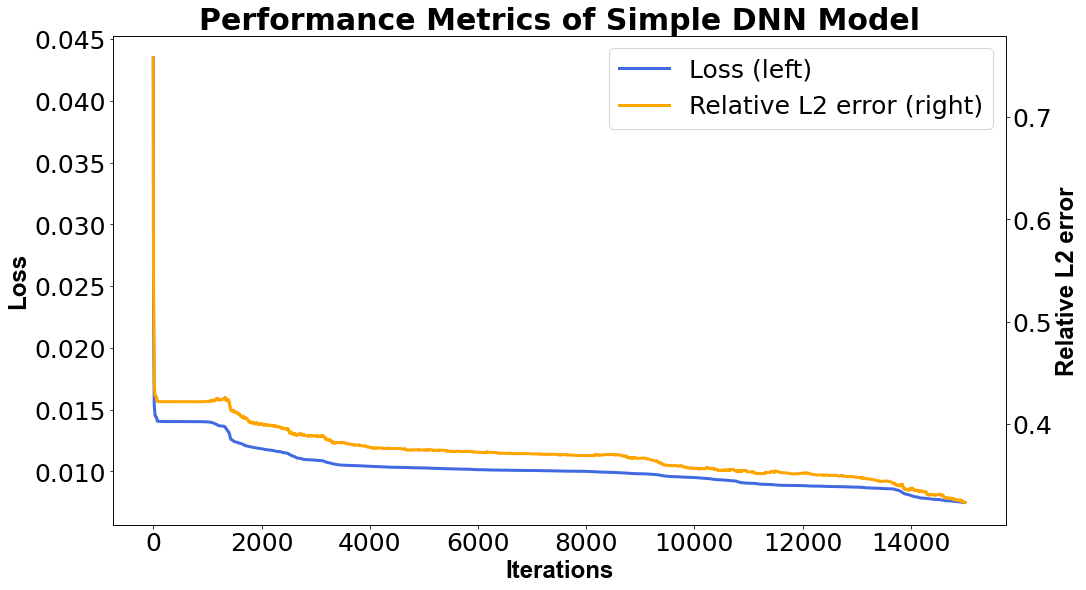

In [22]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Simple DNN Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.09943698625252591
MSE =  0.975948812998302
RMSE =  0.9879012162146082
L2 relative error = 10.556306711158124
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

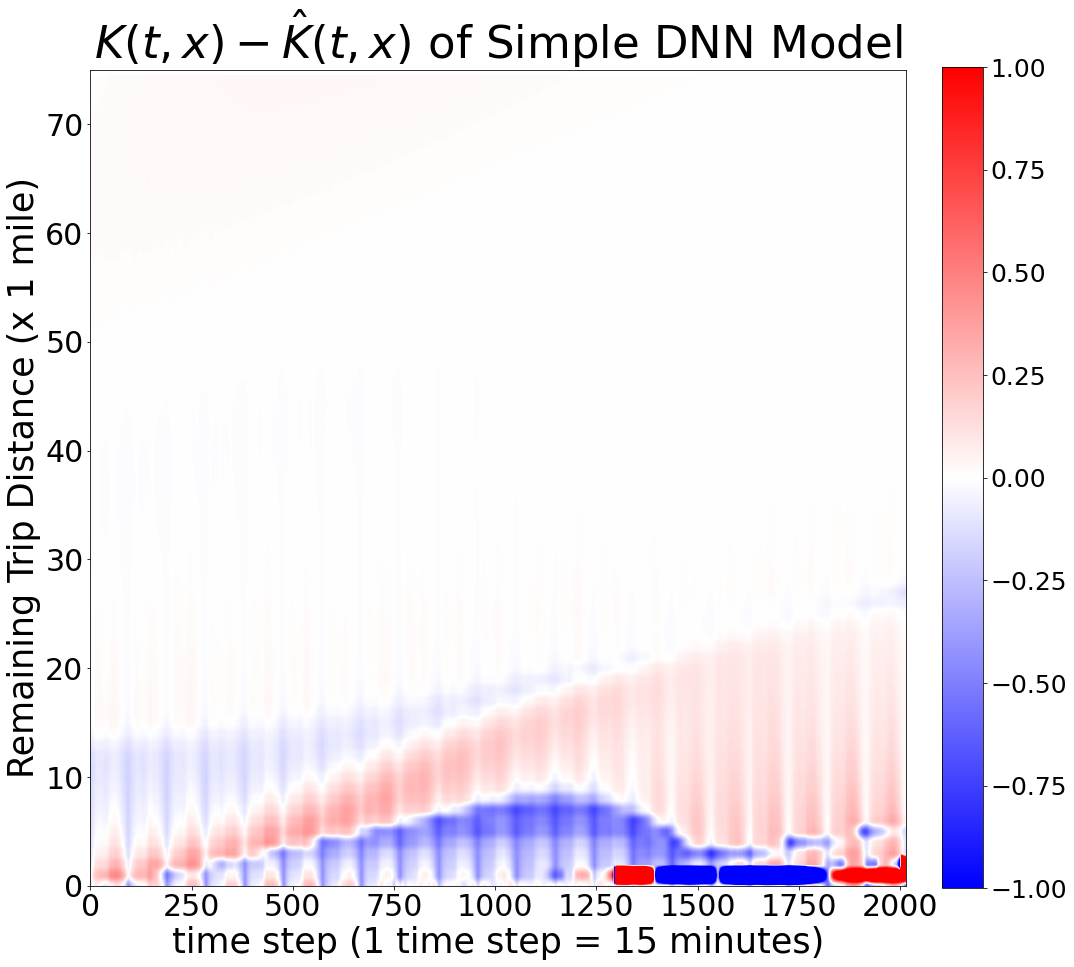

In [21]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

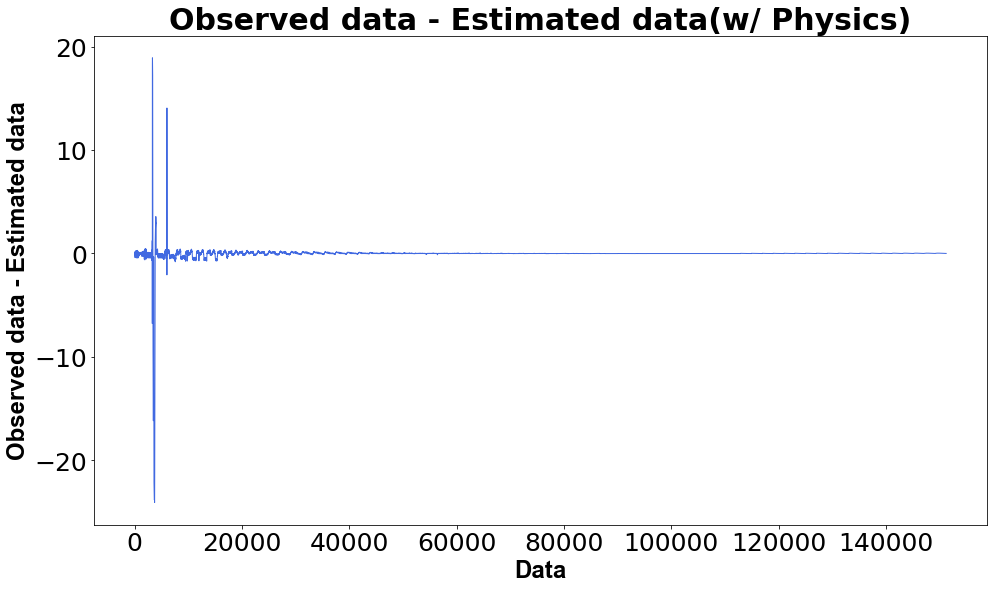

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)